# Error Analysis

Now that I have my final model, I want to look at the individual points of error that are specific to that model. Within this section, I'll evaluate the residuals plots produced on the previous page and investigate the individual outliers to see if the model struggles with a specific type of data.

### Library Imports 

In [248]:
import numpy as np
from numpy.linalg import inv

import pandas as pd
import matplotlib.pyplot as plt
import requests
import pickle
import time
import seaborn as sns
import plotly.express as px

import pycaret
from pycaret.regression import *
from pycaret.regression import RegressionExperiment
from pycaret.regression import get_config
from pycaret.regression import save_model, load_model

from pandas import json_normalize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler,OneHotEncoder

### Data & Model Imports

In [2]:
with open('pickles/df_adj.pkl', 'rb') as f:
    df_adj = pickle.load(f) 
with open('pickles/df_model.pkl', 'rb') as f:
    df_model = pickle.load(f)
with open('pickles/combined_metrics.pkl', 'rb') as f:
    combined_metrics = pickle.load(f)   

In [3]:
with open('pickles/data.pkl', 'rb') as f:
    data = pickle.load(f)
with open('pickles/data_unseen.pkl', 'rb') as f:
    data_unseen = pickle.load(f)   

### Model Setup

In [ ]:
drop_cols = ['country',
             'city',
             'start_year',
             'end_year',
             'cost',
             'currency',
             'cost_km',
             'cost_real',
             'cost_km_2021',
             'time_diff',
             'lat',
             'lng',
             'wrb_class_name',
             'c_length',
             'c_tunnel',
             'inflation_index',
             'ppp_rate'
            
            ]
df_model = df_adj.drop(columns =drop_cols)

In [4]:
cont_feats = df_model.drop(columns=['region', 'sub_region','wrb_class_value','cost_real_2021']).columns.tolist()
cat_feats = ['region', 'sub_region']
ordinal_feats = ['wrb_class_value']

In [5]:
s = setup(data,
          target = 'cost_real_2021',
          ordinal_features ={'wrb_class_value': list(range(0, 30))},
          categorical_features= cat_feats,
          numeric_features= cont_feats,
          normalize = True,
          normalize_method = 'zscore',
          verbose = False,
          feature_selection = False,
          low_variance_threshold = 0.1,
          pca = False, 
          pca_components = 30,
          remove_multicollinearity = False,
          multicollinearity_threshold = 0.3
         )

In [6]:
transformed_data = get_config('X_train')
transformed_data

,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,...,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
471,0.0,42.099998,0.70,29.469999,11.669,0.961,31.0,80.0,1435.0,1,...,83.916664,2010,17,131,0,0,5,20,16.312870,0.736342
533,0.0,19.000000,0.53,10.070000,0.620,8.310,25.0,80.0,1435.0,1,...,69.166664,2016,6,40,2,1,5,18,28.762728,1.315789
342,0.0,4.900000,1.00,4.900000,0.000,0.000,2.0,80.0,1435.0,1,...,102.666664,2018,28,224,0,1,1,56,16.312870,0.408163
72,0.0,17.000000,0.90,15.300000,1.700,0.000,11.0,80.0,1435.0,0,...,53.333332,2010,13,159,0,0,5,19,13.416667,0.647059
800,0.0,28.737000,1.00,28.737000,0.000,0.000,24.0,80.0,1435.0,1,...,43.333332,2020,29,231,0,1,1,58,16.312870,0.835160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681,1.0,9.600000,0.50,4.800000,0.200,4.600,1.0,160.0,1435.0,1,...,90.500000,2010,5,39,2,1,4,21,15.998889,0.104167
199,0.0,13.200000,1.00,13.200000,0.000,0.000,21.0,80.0,1435.0,1,...,81.666664,2005,15,133,0,0,3,29,38.052544,1.590909
21,0.0,3.600000,1.00,3.600000,0.000,0.000,4.0,80.0,1435.0,0,...,48.491665,2020,9,56,1,1,3,31,17.506001,1.111111
373,0.0,26.530001,1.00,26.530001,0.000,0.000,21.0,80.0,1435.0,1,...,46.733334,2019,29,231,0,0,2,49,16.312870,0.791557


### The Model

In [7]:
blended = load_model('blended')
blended_tuned = load_model('blended_tuned')

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


In [8]:
blended_tuned

Pipeline(memory=FastMemory(location=/var/folders/fm/_6kg8xkn3jz4slz27zwpqnhc0000gn/T/joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['rr?', 'length', 'tunnel_per',
                                             'tunnel', 'elevated', 'at_grade',
                                             'stations', 'max_speed',
                                             'track_gauge', 'overhead?', 'year',
                                             'anglo', 'duration',
                                             'country_pop_den', 'area_km',
                                             'population',
                                             'calculated_population',
                                             'c...
                 VotingRegressor(estimators=[('Random Forest Regressor',
                                              RandomForestRegressor(max_features='sqrt',
                                                                    min_samples_split=5,
                                                                    n_estimators=300,
                                                                    n_jobs=-1,
                                                                    random_state=6213)),
                                             ('Light Gradient Boosting Machine',
                                              LGBMRegressor(n_jobs=-1,
                                                            random_state=6213)),
                                             ('CatBoost Regressor',
                                              <catboost.core.CatBoostRegressor object at 0x2980dc250>)],
                                 n_jobs=-1, weights=[0.25, 0.1, 0.65]))])

### The Data

In [9]:
data

,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,...,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
935,0.0,27.100,0.06,1.626,25.474,0.0,26.0,60.0,1435.0,0,...,52.391667,2017,12,157,0,1,4,24,4.730000,0.959410
237,0.0,15.184,1.00,15.184,0.000,0.0,12.0,80.0,1435.0,1,...,114.675000,2020,29,231,0,0,1,52,16.312870,0.790306
306,0.0,21.600,1.00,21.600,0.000,0.0,16.0,80.0,1435.0,1,...,119.166667,2017,23,189,0,0,2,36,16.312870,0.740741
127,0.0,1.700,1.00,1.700,0.000,0.0,2.0,80.0,1435.0,1,...,45.833333,2018,9,63,1,0,4,23,38.052545,1.176471
547,0.0,16.500,1.00,16.500,0.000,0.0,14.0,80.0,1435.0,1,...,89.916667,2007,21,180,0,0,4,9,16.312870,0.848485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,0.0,17.800,1.00,17.800,0.000,0.0,14.0,80.0,1435.0,1,...,114.675000,2016,25,210,0,0,2,37,16.312870,0.786517
312,0.0,12.000,0.00,0.000,12.000,0.0,12.0,60.0,1435.0,0,...,117.500000,1991,13,81,1,1,4,25,21.337222,1.000000
24,0.0,3.600,1.00,3.600,0.000,0.0,3.0,100.0,1435.0,0,...,48.166667,2020,29,231,0,0,1,52,16.312870,0.833333
417,0.0,2.700,0.52,1.404,1.296,0.0,4.0,80.0,1435.0,0,...,44.583333,2020,9,56,1,0,3,28,17.506000,1.481481


In [10]:
data_unseen

,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,...,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
7,1.0,3.8,1.00,3.8,0.00,0.0,4.0,80.0,1432.0,0,...,202.600000,2009,19,124,0,1,3,25,21.699286,1.052632
9,0.0,7.0,1.00,4.0,0.00,0.0,5.0,80.0,1432.0,0,...,202.600000,2000,1,13,1,1,4,5,21.699286,1.250000
13,0.0,12.5,0.84,10.5,2.00,0.0,14.0,80.0,1432.0,0,...,202.600000,1983,1,13,1,1,6,4,21.699286,1.120000
19,0.0,4.9,1.00,4.9,0.00,0.0,5.0,80.0,1435.0,0,...,48.491667,1981,0,6,6,1,8,6,17.506000,1.020408
20,0.0,1.8,1.00,1.8,0.00,0.0,3.0,80.0,1435.0,0,...,48.491667,2006,2,22,3,1,5,16,17.506000,1.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,0.0,6.5,0.00,0.0,0.59,5.9,8.0,60.0,1435.0,1,...,76.583333,2007,2,15,5,0,13,7,11.802000,1.230769
998,0.0,1.6,0.00,0.0,0.00,1.6,2.0,89.0,1435.0,1,...,37.916667,2009,2,17,5,0,12,7,11.802000,1.250000
1002,0.0,9.7,0.00,0.0,0.00,9.7,6.0,60.0,1435.0,1,...,34.666667,2008,2,16,5,0,12,7,11.802000,0.618557
1005,0.0,6.1,0.00,0.0,0.00,6.1,3.0,60.0,1435.0,1,...,34.666667,2010,2,21,4,0,10,9,11.802000,0.491803


### Model Evaluation

In [11]:
finalized_best = finalize_model(blended_tuned)
predictions = predict_model(finalized_best, data=data_unseen)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,673.8190,1283304.0849,1132.8301,0.8242,0.4145,0.3489


In [12]:
predictions['Residuals'] = predictions['cost_real_2021'] - predictions['prediction_label']

In [13]:
outliers = predictions.sort_values(by='Residuals', key=abs, ascending=False)

In [14]:
mean_res = np.mean(outliers['Residuals'])
std_res = np.std(outliers['Residuals'])

outliers['standardized_residuals'] = (outliers['Residuals'] - mean_res) / std_res

In [15]:
high_residuals = outliers[abs(outliers['standardized_residuals'])>3].index.tolist()

In [16]:
high_residuals

[941, 927, 321, 942, 234]

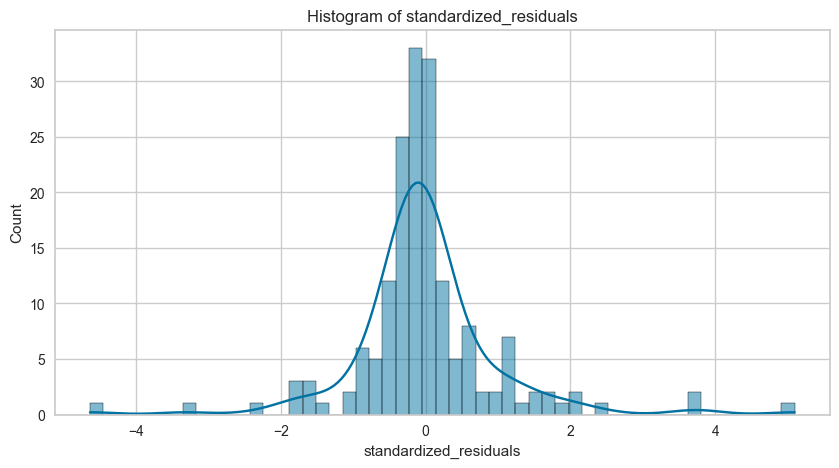

In [17]:
column_to_plot = "standardized_residuals"

plt.figure(figsize=(10, 5))
sns.histplot(outliers[column_to_plot], kde=True)
plt.title(f'Histogram of {column_to_plot}')
plt.show()

In [18]:
len(high_residuals)

5

### Residuals & Leverage

There are a few ways to go about outlier removal. Since I've previously cleaned the dataset and each datapoint that remains has been proven to be accurate and representative, I'll be less strict about eliminating outliers.

Within this section I'll create a list of indexes that are either large outliers by measure of standardized residuals or by their leverage on the previous model iteration.

In [19]:
outliers[abs(outliers['standardized_residuals'])>2]

,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,...,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km,cost_real_2021,prediction_label,Residuals,standardized_residuals
941,0.0,18.000000,1.00,9.000000,0.000000,0.0,5.0,110.0,1600.0,1,...,1,0,4,21,17.299999,0.555556,8968.327148,3213.515140,5754.812008,5.096405
927,0.0,43.000000,1.00,43.000000,0.000000,0.0,32.0,80.0,1435.0,0,...,0,1,2,42,16.007242,0.744186,1916.399780,7188.469291,-5272.069511,-4.638724
321,0.0,58.299999,0.28,16.323999,41.976002,0.0,20.0,130.0,1067.0,1,...,1,1,3,31,21.337223,0.343053,9707.054688,5455.556934,4251.497754,3.769198
942,0.0,42.299999,0.20,8.460000,33.840000,0.0,41.0,80.0,1435.0,0,...,0,1,3,28,12.133509,0.969267,11116.720703,6948.852182,4167.868521,3.695365
234,0.0,48.180000,0.31,48.180000,0.000000,0.0,12.0,120.0,1435.0,1,...,0,0,1,52,16.312870,0.249066,3250.510742,7035.692384,-3785.181641,-3.326019
849,0.0,44.500000,1.00,44.500000,0.000000,0.0,27.0,80.0,1435.0,1,...,0,0,2,37,16.312870,0.606742,10329.908203,7599.899676,2730.008527,2.425945
283,0.0,44.700001,1.00,44.700001,0.000000,0.0,15.0,80.0,1435.0,1,...,0,1,1,67,9.769591,0.335570,3863.733887,6463.890931,-2600.157044,-2.279815
850,0.0,44.200001,1.00,44.200001,0.000000,0.0,24.0,80.0,1435.0,1,...,0,0,1,52,16.312870,0.542986,9680.895508,7388.853021,2292.042487,2.039284
9,0.0,7.000000,1.00,4.000000,0.000000,0.0,5.0,80.0,1432.0,0,...,1,1,4,5,21.699286,1.250000,3974.203857,1686.647376,2287.556481,2.035324


The above data points are all of the datapoints in the set that resulted in a standardized residual above 3. A residual, in this case, is the difference between the predicted cost of a project and the actual cost of the project.

In [20]:
X = data.drop(columns = ['cost_real_2021','region','sub_region'])
X['Intercept'] = 1
X = X[['Intercept'] + [col for col in X if col != 'Intercept']]
X_numeric = X.values

In [21]:
X_unseen = data_unseen.drop(columns = ['cost_real_2021','region','sub_region'])
X_unseen['Intercept'] = 1
X_unseen = X_unseen[['Intercept'] + [col for col in X_unseen if col != 'Intercept']]
X_unseen_numeric = X_unseen.values

In [22]:
H = X_numeric @ np.linalg.inv(X_numeric.T @ X_numeric) @ X_numeric.T
leverage = np.diag(H)

In [23]:
H_unseen = X_unseen_numeric @ np.linalg.pinv(X_unseen_numeric.T @ X_unseen_numeric) @ X_unseen_numeric.T
leverage_unseen = np.diag(H_unseen)

In [24]:
data['leverage'] = leverage
data_unseen['leverage'] = leverage_unseen

In [25]:
data.sort_values(by='leverage',ascending=False)

,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,...,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km,leverage
10,0.0,7.400,0.71,4.970,2.000,0.000,5.0,80.0,1435.0,0,...,2013,23,150,0,1,2,34,21.699286,0.714286,0.683245
829,0.0,15.700,0.38,5.966,9.734,0.000,13.0,80.0,1435.0,1,...,2016,19,225,0,1,4,22,12.140000,0.828025,0.635230
412,0.0,2.500,1.00,2.500,0.000,0.000,1.0,40.0,1520.0,0,...,2016,12,192,0,0,6,15,33.739286,0.400000,0.522019
724,0.0,11.600,0.14,1.624,0.140,9.836,4.0,40.0,1520.0,0,...,2018,11,154,0,1,6,15,33.739286,0.344828,0.437950
663,1.0,3.600,1.00,3.600,0.000,0.000,4.0,80.0,1435.0,1,...,2008,3,27,3,0,5,16,17.506000,1.111111,0.403752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,0.0,17.600,1.00,17.600,0.000,0.000,12.0,80.0,1435.0,1,...,2018,28,224,0,1,1,56,16.312870,0.681818,0.023419
639,0.0,14.500,1.00,14.500,0.000,0.000,11.0,80.0,1435.0,1,...,2020,29,231,0,1,1,58,16.312870,0.758621,0.023064
643,0.0,27.500,1.00,27.500,0.000,0.000,17.0,80.0,1435.0,1,...,2020,29,231,0,1,1,58,16.312870,0.618182,0.022884
642,0.0,21.000,1.00,21.000,0.000,0.000,17.0,80.0,1435.0,1,...,2020,29,231,0,1,1,58,16.312870,0.809524,0.022530


In [26]:
predictions_seen = predict_model(finalized_best, data=data)
predictions_unseen = predict_model(finalized_best, data=data_unseen)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,185.4162,62498.0901,249.9962,0.9909,0.1590,0.1105


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,673.8190,1283304.0849,1132.8301,0.8242,0.4145,0.3489


In [27]:
data['residuals'] = predictions_seen['cost_real_2021'] - predictions_seen['prediction_label']
data_unseen['residuals'] = predictions_unseen['cost_real_2021'] - predictions_unseen['prediction_label']

In [28]:
mean_res = np.mean(data['residuals'])
std_res = np.std(data['residuals'])

data['standardized_residuals'] = (data['residuals'] - mean_res) / std_res

In [29]:
mean_res = np.mean(data_unseen['residuals'])
std_res = np.std(data_unseen['residuals'])

data_unseen['standardized_residuals'] = (data_unseen['residuals'] - mean_res) / std_res

#### Leverage Histogram

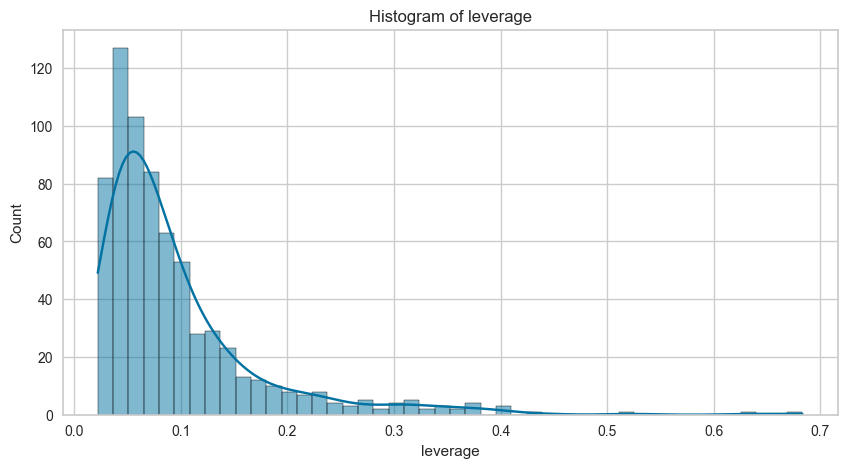

In [30]:
column_to_plot = "leverage"

plt.figure(figsize=(10, 5))
sns.histplot(data[column_to_plot], kde=True)
plt.title(f'Histogram of {column_to_plot}')
plt.show()

#### Residuals vs. Leverage

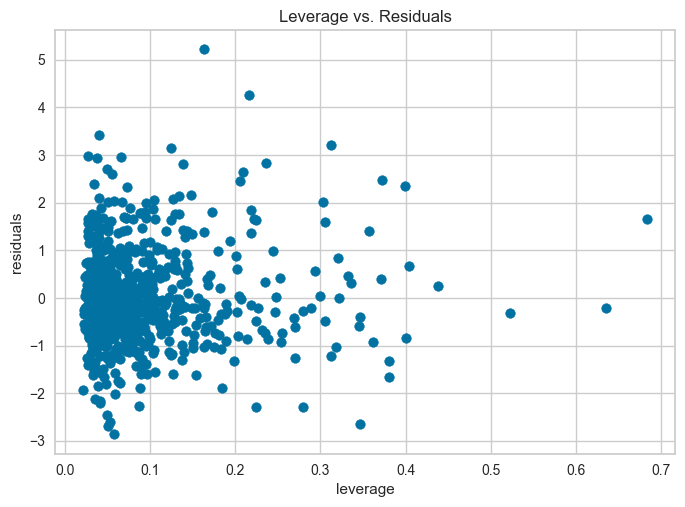

In [31]:
plt.scatter(data['leverage'], data['standardized_residuals'])
plt.xlabel('leverage')
plt.ylabel('residuals')
plt.title('Leverage vs. Residuals')
plt.show()

From the above plots, we can see 2 things:

1) Several well distributed outliers in the long right tail
2) A tight, low leverage grouping around 0. 

Because the outliers aren't (all) obvious, I'll generate the cook's distance for each point to identify which points are outliers.

#### Cooks Distance

In [32]:
p = X.shape[1]
mse = np.mean(data['residuals'] ** 2)
data['cooks_distance'] = (data['residuals'] ** 2 / (p * mse)) * (data['leverage'] / (1 - data['leverage']) ** 2)
data.sort_values(by='cooks_distance',ascending=False)

,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,...,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km,leverage,residuals,standardized_residuals,cooks_distance
10,0.0,7.40,0.71,4.970,2.000,0.0,5.0,80.0,1435.0,0,...,0,1,2,34,21.699286,0.714286,0.683245,414.781972,1.656853,2.840262e-01
932,0.0,35.00,0.13,4.550,30.450,0.0,29.0,95.0,1435.0,0,...,0,1,5,15,0.000000,0.828571,0.312190,805.511823,3.219800,1.038040e-01
923,0.0,30.00,0.51,15.300,14.700,0.0,7.0,100.0,1067.0,1,...,1,1,4,22,17.300000,0.233333,0.163838,1304.682599,5.216519,9.670129e-02
949,0.0,32.00,0.00,0.000,32.000,0.0,21.0,80.0,1435.0,0,...,4,0,11,8,11.802000,0.656250,0.216386,1063.759349,4.252809,9.667225e-02
786,0.0,42.30,0.35,14.805,27.495,0.0,43.0,80.0,1435.0,1,...,0,1,3,33,12.133509,1.016548,0.399847,586.029813,2.341857,9.242703e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
676,0.0,9.05,1.00,9.050,0.000,0.0,5.0,80.0,1435.0,1,...,0,1,1,58,16.312870,0.552486,0.049182,-1.906306,-0.009930,4.792811e-08
635,0.0,10.00,1.00,10.000,0.000,0.0,4.0,80.0,1435.0,1,...,0,1,1,58,16.312870,0.400000,0.026455,2.637118,0.008244,4.705851e-08
18,0.0,0.80,1.00,0.800,0.000,0.0,1.0,80.0,1435.0,0,...,4,1,6,7,17.506000,1.250000,0.156552,-0.791108,-0.005469,3.338893e-08
76,0.0,0.70,1.00,0.700,0.000,0.0,1.0,80.0,1435.0,1,...,1,1,2,34,23.628823,1.428571,0.050231,1.316892,0.002963,2.341130e-08


In [33]:
fig = px.bar(data, x=data['cooks_distance'], y=data.index, orientation='h', title="Cook's Distance",
             color_discrete_sequence=['black'], width=1000)

# Change the background color of the plot to a light gray for better contrast
fig.update_layout(plot_bgcolor='blanchedalmond', paper_bgcolor='blanchedalmond')

fig.show()

In [ ]:
p = X_unseen.shape[1]
mse = np.mean(data_unseen['residuals'] ** 2)
data_unseen['cooks_distance'] = (data_unseen['residuals'] ** 2 / (p * mse)) * (data_unseen['leverage'] / (1 - data_unseen['leverage']) ** 2)
data_unseen.sort_values(by='cooks_distance',ascending=False)

,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,...,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km,leverage,residuals,standardized_residuals,cooks_distance
391,0.0,32.95,100.00,32.950,0.000,0.0,6.0,80.0,1435.0,1,...,0,1,3,29,16.312870,0.182094,0.999214,-2062.977616,-1.805564,8.125661e+04
927,0.0,43.00,1.00,43.000,0.000,0.0,32.0,80.0,1435.0,0,...,0,1,2,42,16.007242,0.744186,0.904752,-5272.069511,-4.638724,3.272727e+01
941,0.0,18.00,1.00,9.000,0.000,0.0,5.0,110.0,1600.0,1,...,1,0,4,21,17.300000,0.555556,0.580208,5754.812008,5.096405,1.287369e+00
942,0.0,42.30,0.20,8.460,33.840,0.0,41.0,80.0,1435.0,0,...,0,1,3,28,12.133509,0.969267,0.547820,4167.868521,3.695365,5.495024e-01
321,0.0,58.30,0.28,16.324,41.976,0.0,20.0,130.0,1067.0,1,...,1,1,3,31,21.337222,0.343053,0.511592,4251.497754,3.769198,4.576861e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,0.0,2.50,1.00,2.500,0.000,0.0,2.0,80.0,1435.0,0,...,1,0,3,33,10.648056,0.800000,0.225727,-8.626200,0.008129,3.307976e-07
978,0.0,18.00,0.00,0.000,0.490,17.5,23.0,60.0,1435.0,1,...,4,0,10,9,11.802000,1.277778,0.253705,5.951754,0.020999,1.905127e-07
998,0.0,1.60,0.00,0.000,0.000,1.6,2.0,89.0,1435.0,1,...,5,0,12,7,11.802000,1.250000,0.337107,2.155648,0.017648,4.208843e-08
339,0.0,3.97,0.00,0.000,3.970,0.0,2.0,80.0,1435.0,0,...,0,1,2,35,16.312870,0.503778,0.141711,2.737292,0.018161,1.701782e-08


#### Cooks Distance Removal Using 4/n rule

The Cook's Distance combines the insights provided by both the residuals and the leverage features to create 1 feature that can identify which high residual points have a high leverage. A rule of thumb for determining which data are influential and which are not is the 4/n rule, where n is the number of observations in the dataset.

Any datapoint with a Cook's Distance above this threshold will be evaluated.

In [ ]:
n_seen = data.shape[0]
n_unseen= data_unseen.shape[0]

threshold_seen = 4/n_seen
threshold_unseen = 4/n_unseen

threshold_seen

0.005788712011577424

In [ ]:
threshold_unseen

0.023121387283236993

In [ ]:
cooks_outliers_seen = data[data['cooks_distance']>threshold_seen].sort_values(by='cooks_distance',ascending=False).index
cooks_outliers_unseen = data_unseen[data_unseen['cooks_distance']>threshold_unseen].sort_values(by='cooks_distance',ascending=False).index

### Cook's Distance Evaluation

I'll need to look at each datapoint to determine why the points are influential. Similar to sheet 6, I'll briefly describe the data and then identify what I intend to do with the data. Once again, it's not my goal to drop data, but I will drop the data if the information cannot be reconciled.

In [ ]:
pd.set_option('display.max_columns', None)

#### Seen Data

In [ ]:
cooks_outliers_seen

Int64Index([  10,  932,  923,  949,  786,  807,  785,  803,  722,   16,  899,
              15,  944,  179, 1012,  181,  530,   81,  631,  847,  488,  190,
             816,  931,   14,  920,  780,  723,  905,  835,  848,  650,   82,
             177,    8,  936,  375,    1,  689,  781,  545,   30,  663,  836,
             416,  211,  267,  814,  752,  889,  757,  520,  162,  908,  693,
             261,  462,  285,  921],
           dtype='int64')

In [ ]:
cooks_drop=[]

In [ ]:
df_adj.loc[[391]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
391,CN,Nanjing,2018,2022,0.0,32.95,100.0,32.95,0.0,0.0,6.0,80.0,1435.0,1,9399.67,CNY,2013,0.272952,2565.660701,77.865272,0.0,0.0,0.0,1.16,2976.166414,90.323715,4,212.35,Asia,Eastern Asia,1398.69,32.0608,118.7789,8422000.0,7,6.918073e+06,4946.109138,69.489729,4711.635127,Fluvisols,11.0,4.0,0.0,1.0,4.0,1.0,0.0,14.0,1.0,0.0,0.0,0.0,21.0,7.0,0.0,0.0,1.0,1.0,4.0,14.0,0.0,2.0,12.0,0.0,2.0,4.0,1.0,1.0,0.0,0.0,2.0,17.0,15.766667,11.308333,20.2,85.083333,2013,25,214,0,1,3,29,16.31287,0.182094


This is the Line S4 Nanjing-Chuzhou Phase 1 (Chuzhou Section) in Nanjing. It's unclear what is included as part of this phase and so I'll remove the line [remove]

In [42]:
cooks_drop.append(391)

In [43]:
df_adj.loc[[428]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
428,IT,Rome,2013,2023,0.0,3.6,1.0,2.7,0.0,0.0,2.0,80.0,1435.0,1,861.0,EUR,2018,1.467957,1263.910977,351.086383,2.7,2.7,0.0,1.08,1363.888863,378.858018,10,204.322226,Europe,Southern Europe,842.0,41.8931,12.4828,2872800.0,2,2.849387e+06,3384.070223,3.86843,30230.2263,Luvisols,18.0,1.0,0.0,1.0,1.0,0.0,8.0,17.0,1.0,0.0,0.0,0.0,14.0,1.0,1.0,0.0,2.0,8.0,0.0,18.0,0.0,2.0,3.0,0.0,0.0,4.0,2.0,0.0,0.0,0.0,12.0,42.0,16.0,11.1,21.0,66.25,2018,9,63,1,1,3,28,38.052545,0.740741


In [44]:
cooks_drop.append(428)

In [45]:
df_adj.loc[[941]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
941,AU,Melbourne,2018,2025,0.0,18.0,1.0,9.0,0.0,0.0,5.0,110.0,1600.0,1,11000.0,AUD,2021,0.690809,7598.899,422.161056,0.0,0.0,1.0,1.0,8968.326984,422.161056,7,3.335312,Oceania,Australia and New Zealand,2080.0,-37.8142,144.9631,4529500.0,-1,4603783.8,2213.357596,0.989104,57527.17703,Luvisols,18.0,1.0,1.0,0.0,0.0,7.0,5.0,9.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,3.0,6.0,3.0,12.0,4.0,4.0,8.0,0.0,2.0,6.0,5.0,7.0,0.0,0.0,9.0,18.0,14.675,9.541667,19.825,56.65,2020,7,55,1,0,4,21,17.3,0.555556


In [46]:
cooks_drop.append(941)

In [47]:
df_adj.loc[[927]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
927,SG,Singapore,2014,2024,0.0,43.0,1.0,43.0,0.0,0.0,32.0,80.0,1435.0,0,12300.0,SGD,2019,1.140573,1808.1,42.048837,0.0,0.0,1.0,1.06,1916.399766,44.567436,10,7965.878492,Asia,South-eastern Asia,523.0,1.3,103.8,5983000.0,1,5.942590e+06,11362.505517,1.709393,82807.6,Cambisols,6.0,14.0,0.0,1.0,2.0,3.0,0.0,17.0,0.0,0.0,0.0,17.0,8.0,2.0,0.0,16.0,0.0,0.0,3.0,0.0,2.0,1.0,1.0,8.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,14.0,28.25,25.0,31.6,176.25,2019,21,133,0,1,2,42,16.007242,0.744186


In [48]:
cooks_drop.append(927)

In [49]:
df_adj.loc[[786]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
786,IN,Delhi,2019,2025,0.0,42.3,0.35,14.805,27.495,0.0,43.0,80.0,1435.0,1,215363.5,INR,2022,0.041564,8951.292642,211.614483,0.0,0.0,0.0,1.0,8951.292642,211.614483,6,469.659567,Asia,Southern Asia,700.0,28.61,77.23,32226000.0,-2,3.400956e+07,48585.081879,88.900103,1580.05946,Luvisols,18.0,3.0,0.0,0.0,0.0,3.0,2.0,15.0,0.0,0.0,2.0,2.0,14.0,3.0,0.0,0.0,0.0,6.0,1.0,21.0,1.0,5.0,0.0,1.0,0.0,5.0,1.0,3.0,0.0,0.0,9.0,214.0,25.35,19.0,31.7,69.166667,2020,11,126,0,1,3,33,12.133509,1.016548


This is for the Phase 4 second half in Delhi. The wording of this item makes it difficult to verify. [remove]

In [ ]:
cooks_drop.append(786)

In [51]:
df_adj.loc[[949]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
949,US,Honolulu,2011,2026,0.0,32.0,0.0,0.0,32.0,0.0,21.0,80.0,1435.0,0,9930.0,USD,2018,1.0,9930.0,310.3125,0.0,0.0,1.0,1.08,10715.48286,334.858839,15,35.730096,Americas,Northern America,399.0,21.3294,-157.846,835291.0,2,818832.467405,2052.211698,2.248539,56863.3715,Cambisols,6.0,4.0,0.0,0.0,1.0,4.0,0.0,17.0,1.0,0.0,0.0,16.0,3.0,2.0,0.0,0.0,2.0,5.0,5.0,6.0,3.0,4.0,1.0,0.0,1.0,4.0,0.0,1.0,0.0,0.0,12.0,76.0,25.55,21.9,29.2,34.583333,2018,3,24,4,0,11,8,11.802,0.65625


This is the HART in Honolulu. Previously adjusted in section 6. [drop]

In [52]:
cooks_drop.append(949)

In [53]:
df_adj.loc[[1012]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
1012,UK,Tyne-and-Wear,1980,2002,0.0,77.0,0.08,6.16,70.84,0.0,57.0,80.0,1435.0,1,397.0,GBP,1980,2.002888,795.146601,10.326579,0.0,0.0,1.0,3.288471,2614.816439,33.958655,22,0.0,Europe,Western Europe,539.0,54.982409,-1.564419,1107000.0,40,1007000.0,1868.274583,1.477994,24504.381435,Cambisols,6.0,0.0,0.0,0.0,0.0,3.0,1.0,22.0,3.0,0.0,0.0,1.0,12.0,5.0,0.0,3.0,3.0,8.0,1.0,11.0,0.0,2.0,3.0,0.0,11.0,3.0,2.0,0.0,1.0,2.0,1.0,37.0,10.6,7.5,13.7,69.583333,1980,6,82,1,0,5,27,28.591909,0.74026


This is the Tyne and Wear line. I previously verified this data. [drop]

In [54]:
cooks_drop.append(1012)

In [55]:
df_adj.loc[[923]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
923,AU,Sydney,2017,2024,0.0,30.0,0.51,15.3,14.7,0.0,7.0,100.0,1067.0,1,15500.0,AUD,2021,0.690809,10707.54046,356.918015,0.0,0.0,1.0,1.0,10707.54046,356.918015,7,3.335312,Oceania,Australia and New Zealand,1687.0,-33.8678,151.21,4840600.0,-1,4902075.62,2905.794677,0.989104,57527.17703,Cambisols,6.0,10.0,0.0,0.0,0.0,9.0,1.0,11.0,2.0,0.0,0.0,6.0,1.0,2.0,0.0,1.0,2.0,5.0,3.0,6.0,3.0,8.0,6.0,0.0,1.0,4.0,2.0,1.0,0.0,0.0,11.0,72.0,18.191667,14.225,22.133333,107.908333,2020,7,55,1,1,4,22,17.3,0.233333


This is the Metro City & SW Metro in Sydney. The most recent cost estimate has the total cost at 20.5Bn AUD.[ adjust]

In [56]:
data.loc[923,'length'] = 30
data.loc[923,'cost_real_2021'] = 20500*0.690809*1

In [57]:
df_adj.loc[[932]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
932,AE,Dubai,2005,2010,0.0,35.0,0.13,4.55,30.45,0.0,29.0,95.0,1435.0,0,13133.4,AED,2005,0.675931,8173.466423,233.527612,0.0,0.0,0.0,1.39,10952.445007,312.927,5,60.278696,Asia,Western Asia,712.0,25.2631,55.2972,3331420.0,15,2.680443e+06,3764.666638,64.565649,36495.76527,Solonchaks,25.0,0.0,0.0,0.0,0.0,5.0,5.0,2.0,0.0,0.0,0.0,1.0,11.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,43.0,0.0,0.0,0.0,0.0,10.0,28.75,23.7,33.9,7.916667,2005,7,86,0,1,5,15,0.0,0.828571


In [ ]:
cooks_drop.append(932)

In [58]:
df_adj.loc[[807]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
807,BH,Bahrain,2020,2025,1.0,72.7,0.0,0.0,72.7,0.0,18.0,65.0,1435.0,1,1500.0,BD,2010,6.016569,9024.853061,124.138281,0.0,0.0,0.0,1.24,11190.8178,153.931469,5,1592.709974,Asia,Western Asia,760.0,26.0667,50.5577,1487202.0,10,1.366504e+06,1798.031695,50.161435,26562.97,Regosols,24.0,0.0,0.0,0.0,0.0,11.0,1.0,1.0,0.0,0.0,0.0,0.0,7.0,1.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,27.0,2.0,0.0,0.0,1.0,55.0,29.1,23.5,34.8,9.166667,2010,5,59,1,0,14,7,0.0,0.247593


This is the 2nd phase of the Bahrain metro system. There is an abundance of information regarding phase 1, however very little regarding phase 2. [remove]

In [59]:
cooks_drop.append(807)

In [60]:
df_adj.loc[[722]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
722,BR,Salvador,2020,2022,0.0,23.3,0.0,0.0,23.3,0.0,26.0,80.0,1000.0,0,3582.8,BRL,2021,0.395862,1418.295409,60.871048,0.0,0.0,0.0,1.0,1418.295409,60.871048,2,25.507625,Americas,Latin America and the Caribbean,693.8,-12.9747,-38.4767,2886698.0,-1,2.914988e+06,4201.481177,25.276877,8813.989806,Ferralsols,10.0,8.0,0.0,11.0,0.0,7.0,0.0,7.0,0.0,0.0,0.0,21.0,8.0,7.0,0.0,1.0,1.0,1.0,5.0,4.0,3.0,2.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,15.0,29.4,24.0,29.4,159.166667,2020,16,188,0,1,4,24,16.784444,1.11588


This is the Bahia SkyRail. I've previously evaluated this outlier and so now I will remove it. [remove]

In [61]:
cooks_drop.append(722)

In [62]:
df_adj.loc[[803]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
803,IN,Hyderabad,2012,2020,0.0,72.0,0.0,0.0,72.0,0.0,66.0,80.0,1435.0,1,188000.0,INR,2016,0.050254,9447.840558,131.220008,0.0,0.0,0.0,1.13,10676.05983,148.278609,8,450.23572,Asia,Southern Asia,1404.0,17.385,78.4867,10494000.0,4,9.495924e+06,6763.478636,88.900103,1580.05946,Luvisols,18.0,12.0,0.0,0.0,0.0,5.0,2.0,12.0,1.0,0.0,0.0,1.0,10.0,2.0,0.0,0.0,0.0,3.0,4.0,17.0,1.0,1.0,0.0,1.0,0.0,4.0,4.0,0.0,0.0,0.0,16.0,505.0,26.95,20.9,33.2,69.166667,2016,10,127,0,1,3,33,12.133509,0.916667


This is the 1st phase of the Hyderabad metro. There is a discrepancy between the reported length and cost. Some of the reported costs match the value shown, but given different lengths. [remove]

In [63]:
cooks_drop.append(803)

In [64]:
df_adj.loc[[899]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
899,SA,Riyadh,2014,2019,0.0,29.9,0.0,0.0,29.9,0.0,6.0,90.0,1435.0,0,12487.5,SAR,2013,0.600072,7493.402206,250.615458,0.0,0.0,0.0,1.16,8692.346559,290.713932,5,14.645134,Asia,Western Asia,1673.0,24.6333,46.7167,7237000.0,7,6.339295e+06,3789.178117,50.161435,756.0,Regosols,24.0,0.0,0.0,0.0,0.0,2.0,9.0,3.0,0.0,0.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0,29.0,1.0,0.0,0.0,1.0,586.0,25.85,18.3,33.6,9.166667,2013,3,22,4,1,6,16,0.0,0.200669


This is the Riyadh purple line. I've previously reviewed this datapoint and now I'll remove it. [remove]

In [65]:
cooks_drop.append(899)

In [66]:
df_adj.loc[[829]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
829,ID,Jakarta,2013,2019,0.0,15.7,0.38,5.966,9.734,0.0,13.0,80.0,1435.0,1,13776070.0,IDR,2016,0.000221,3049.08209,194.20905,0.0,0.0,0.0,1.13,3445.462762,219.456227,6,139.466062,Asia,South-eastern Asia,3546.0,-6.175,106.8275,33756000.0,4,3.171679e+07,8944.384022,72.949046,3331.695115,Ferralsols,10.0,11.0,0.0,3.0,1.0,2.0,0.0,6.0,0.0,0.0,0.0,24.0,13.0,4.0,0.0,18.0,0.0,0.0,3.0,0.0,3.0,3.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,27.3,23.35,31.3,159.5,2016,19,225,0,1,4,22,12.14,0.828025


This is the MRT first phase in Jakarta. The [official](https://jakartamrt.co.id/id/proyek/fase-1), initial estimate was given as 12.5 trillion IDR. It appears the cost had risen to 16 trillion, per local news sources as of 2023.

In [67]:
data.loc[829,'length'] = 15.7
data.loc[829,'cost_real_2021'] = 16006070*0.000221*1.13

In [68]:
df_adj.loc[[631]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
631,CZ,Prague,2021,2029,0.0,10.5,0.9,9.45,1.0,0.0,10.0,80.0,1435.0,0,73000.0,CZK,2025,0.077369,5647.934968,537.898568,0.0,0.0,0.0,1.0,5647.934968,537.898568,8,138.575929,Europe,Eastern Europe,496.2,50.0875,14.4214,1335084.0,-5,1.362000e+06,2744.861245,0.441796,17829.69832,Luvisols,18.0,0.0,1.0,1.0,0.0,5.0,4.0,12.0,13.0,0.0,0.0,0.0,7.0,0.0,2.0,0.0,8.0,13.0,0.0,14.0,0.0,1.0,0.0,0.0,1.0,5.0,1.0,1.0,0.0,0.0,7.0,199.0,8.85,4.3,13.4,43.75,2020,15,99,1,1,3,30,13.3,0.952381


This is for Line D in Prague. The updated construction cost is 98Bn CZK.[adjust]

In [69]:
data.loc[631,'length'] = 10.5
data.loc[631,'cost_real_2021'] = 97790*0.077369*1

In [70]:
df_adj.loc[[15]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
15,HK,Hong Kong,1994,1998,0.0,34.0,0.24,8.16,5.84,20.0,9.0,80.0,1432.0,0,34000.0,HKD,1996,0.130742,4445.232965,130.742146,0.0,0.0,0.0,1.73,7690.253029,226.183913,4,676.0,Asia,Eastern Asia,290.0,22.3,114.2,7450000.0,24,6.546710e+06,22574.863522,91.142996,1653.430868,Acrisols,0.0,37.0,0.0,3.0,4.0,0.0,0.0,15.0,0.0,0.0,0.0,13.0,4.0,3.0,0.0,1.0,0.0,3.0,4.0,5.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,23.5,21.6,26.0,202.6,1996,1,13,1,1,5,5,21.699286,0.264706


This is the Airport Railway in Hong Kong, the overall cost is reported to be 35.1Bn HKD instead of the provided 34Bn. [adjust]

In [71]:
data.loc[15,'length'] = 34
data.loc[15,'cost_real_2021'] = 35100*0.130742*1.73

In [72]:
df_adj.loc[[321]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
321,JP,Tokyo,1997,2005,0.0,58.3,0.28,16.324,41.976,0.0,20.0,130.0,1067.0,1,949400.0,JPY,2001,0.006683,6344.48023,108.824704,0.0,0.0,0.0,1.53,9707.054752,166.501797,8,348.831276,Asia,Eastern Asia,6993.0,35.6897,139.6922,37732000.0,19,3.120057e+07,4461.686312,2.220306,25769.0,Cambisols,6.0,15.0,0.0,2.0,6.0,0.0,0.0,17.0,2.0,0.0,0.0,0.0,7.0,16.0,0.0,0.0,2.0,4.0,1.0,11.0,0.0,1.0,4.0,0.0,1.0,2.0,3.0,0.0,0.0,0.0,3.0,40.0,15.791667,12.016667,19.541667,117.5,2001,13,77,1,1,3,31,21.337222,0.343053


This is the Tsukuba Express in Tokyo. The data are correct. [keep]

In [73]:
cooks_drop.append(321)

In [74]:
df_adj.loc[[920]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
920,VN,Ho Chi Minh City,2012,2021,0.0,19.7,0.13,2.561,17.139,0.0,14.0,80.0,1435.0,1,43600000.0,VND,2016,0.000137,5959.856164,302.53077,0.0,0.0,0.0,1.13,6734.637466,341.85977,9,297.16143,Asia,South-eastern Asia,2165.0,10.7756,106.7019,15136000.0,4,1.361657e+07,6289.408139,43.5672,3756.49,Fluvisols,11.0,9.0,0.0,1.0,1.0,8.0,0.0,19.0,0.0,0.0,0.0,6.0,34.0,4.0,0.0,0.0,0.0,1.0,2.0,2.0,1.0,0.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,14.0,27.5,24.6,30.4,165.166667,2016,34,374,0,1,3,27,20.403333,0.71066


This is line 1 in Ho Chi Minh City. The [overall cost](https://www.vinhomescentralpark.co/tuyen-metro-1-cua-tp-hcm-bi-tang-von-len-47-000-ty-dong/#:~:text=Kinh%20ph%C3%AD%20x%C3%A2y%20d%E1%BB%B1ng%20tuy%E1%BA%BFn,1%2C09%20t%E1%BB%B7%20USD).) has increased to 47 trillion VND. [update]

In [75]:
data.loc[920,'length'] = 19.7
data.loc[920,'cost_real_2021'] = 47600000.0*0.000137*1.13

In [76]:
df_adj.loc[[835]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
835,BR,Sao Paulo,2012,2021,0.0,7.7,0.0,0.0,7.7,0.0,8.0,80.0,690.0,0,3700.0,BRL,2016,0.468805,1734.5785,225.269935,0.0,0.0,0.0,1.129009,1958.354738,254.331784,9,24.749475,Americas,Latin America and the Caribbean,7947.0,-23.55,-46.6333,23086000.0,4,2.231748e+07,2808.289448,25.276877,8813.989806,Ferralsols,10.0,8.0,0.0,1.0,1.0,7.0,0.0,13.0,0.0,0.0,0.0,20.0,3.0,4.0,0.0,0.0,0.0,14.0,10.0,3.0,3.0,3.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,4.0,761.0,8.55,16.8,21.45,121.25,2016,17,239,0,1,4,23,16.784444,1.038961


This is line 17 in Sao Paulo. The initial cost estimate was 3.7B BRL, but has risen to 5.1B BRL by the end of the project.

In [77]:
data.loc[835,'length'] = 7.7
data.loc[835,'cost_real_2021'] = 5100.0*0.468805*1.129009

In [78]:
df_adj.loc[[931]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
931,AE,Dubai,2006,2010,0.0,22.5,0.35,7.875,14.625,0.0,20.0,95.0,1435.0,0,8445.0,AED,2006,0.622342,5255.67819,233.585697,0.0,0.0,0.0,1.34,7042.608775,313.004834,4,68.979921,Asia,Western Asia,712.0,25.2631,55.2972,3331420.0,14,2.719577e+06,3819.63077,54.026316,35495.76527,Solonchaks,25.0,0.0,0.0,0.0,0.0,5.0,5.0,2.0,0.0,0.0,0.0,1.0,11.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,43.0,0.0,0.0,0.0,0.0,10.0,28.75,23.7,33.9,7.916667,2006,7,83,0,1,6,15,0.0,0.888889


This is the Phase 2 - Green Line in Dubai. The construction details aren't clear. [remove]

In [79]:
cooks_drop.append(931)

In [80]:
df_adj.loc[[944]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
944,CN,Huizhou,2018,2023,0.0,71.2,0.2,14.24,0.0,56.96,27.0,80.0,1435.0,1,40000.0,CNY,2018,0.236451,9458.058005,132.837893,0.0,0.0,0.0,1.08,10214.70265,143.464925,5,148.838644,Asia,Eastern Asia,2672.0,23.1115,114.4152,2509243.0,2,2.375801e+06,889.146973,37.855836,8016.431435,Fluvisols,11.0,20.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,7.0,27.0,4.0,0.0,1.0,0.0,4.0,7.0,2.0,2.0,1.0,2.0,3.0,0.0,1.0,0.0,1.0,0.0,0.0,5.0,25.0,22.9,18.7,27.2,140.416667,2018,28,224,0,0,2,47,16.31287,0.379213


This is line 1 in Huizhou. There's a lack of information that I trust for this datapoint. [remove]

In [81]:
cooks_drop.append(944)

In [82]:
df_adj.loc[[325]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
325,IN,Mumbai,2009,2019,0.0,20.2,0.0,0.0,20.2,0.0,17.0,80.0,0.0,0,30000.0,INR,2014,0.054388,1631.627556,80.773641,0.0,0.0,0.0,1.14,1860.055413,92.081951,10,439.678093,Asia,Southern Asia,976.0,19.0761,72.8775,24973000.0,6,2.270432e+07,23262.621359,92.875461,1145.143244,Vertisols,29.0,3.0,0.0,1.0,1.0,5.0,1.0,7.0,0.0,0.0,0.0,0.0,9.0,7.0,0.0,0.0,0.0,12.0,6.0,4.0,1.0,5.0,0.0,1.0,0.0,2.0,8.0,0.0,0.0,0.0,22.0,6.0,27.5,22.7,32.4,182.083333,2014,10,126,0,1,3,29,12.133509,0.841584


This is the Mumbai Monorail. The data are accurate. [keep]

In [83]:
df_adj.loc[[263]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
263,TR,Istanbul,2011,2019,1.0,63.0,0.1,6.3,0.0,56.7,36.0,120.0,1435.0,1,3115.2,TRY,2015,0.860251,2679.852587,42.537343,63.0,6.3,0.0,1.14,3055.03195,48.492571,8,103.486322,Asia,Western Asia,1471.0,41.0136,28.955,16079000.0,5,1.503628e+07,10221.805132,13.702734,11006.27952,Cambisols,6.0,6.0,1.0,2.0,3.0,0.0,4.0,27.0,3.0,0.0,0.0,1.0,5.0,0.0,0.0,0.0,3.0,3.0,1.0,15.0,0.0,6.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,9.0,41.0,14.458333,10.383333,18.491667,58.083333,2015,6,86,1,1,5,16,5.337857,0.571429


This is the CR3 in Istanbul. There is limited information for this datapoint. [remove]

In [84]:
cooks_drop.append(263)

In [85]:
df_adj.loc[[816]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
816,VN,Hanoi,2010,2013,0.0,12.5,0.32,4.0,8.5,0.0,12.0,80.0,1435.0,0,3430000.0,VND,2016,0.000137,469.91,37.5928,0.0,0.0,0.0,1.13,530.9983,42.479864,3,297.16143,Asia,South-eastern Asia,319.56,21.0283,105.8542,8246600.0,4,7.139413e+06,22341.386565,43.5672,3756.49,Fluvisols,11.0,15.0,0.0,3.0,3.0,8.0,1.0,10.0,0.0,0.0,0.0,5.0,20.0,6.0,0.0,0.0,0.0,0.0,6.0,3.0,3.0,2.0,1.0,3.0,0.0,0.0,2.0,1.0,0.0,0.0,5.0,17.0,24.55,21.1,28.1,134.166667,2016,34,374,0,1,3,27,20.403333,0.96


This is Hanoi metro Line 3. The cost is expected to be 1.9 trillion VND. [adjust]

In [86]:
data.loc[816,'length'] = 12.5
data.loc[816,'cost_real_2021'] = 19000000*0.000137*1.13

In [87]:
df_adj.loc[[190]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
190,DE,Munich,1965,1971,1.0,11.4,0.36,4.104,7.296,0.0,5.0,80.0,1435.0,1,459.0,DM,1968,1.075269,493.548387,43.293718,0.0,0.0,0.0,7.79,3844.741935,337.258065,6,221.391212,Europe,Western Europe,518.0,48.1375,11.575,2606021.0,52,1.851048e+06,3573.452356,16.0,2761.0,Cambisols,6.0,0.0,4.0,1.0,3.0,2.0,1.0,20.0,5.0,0.0,0.0,0.0,14.0,6.0,0.0,1.0,3.0,9.0,1.0,12.0,0.0,4.0,0.0,0.0,1.0,3.0,1.0,1.0,0.0,0.0,4.0,526.0,9.191667,5.25,13.133333,81.191667,1968,0,4,7,1,10,5,17.506,0.438596


This is the S-Bahn Stammstrecke. Due to the time period for this project, I'll remove it. [remove]

In [88]:
cooks_drop.append(190)

In [89]:
df_adj.loc[[16]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
16,HK,Hong Kong,2012,2022,1.0,17.0,0.88,14.96,2.04,0.0,9.0,80.0,1435.0,0,90700.0,HKD,2017,0.16635,1509.248,5335.294118,0.0,0.0,0.0,1.11,1668.411785,98.14187,10,7041.142857,Asia,Eastern Asia,290.0,22.3,114.2,7450000.0,3,7.330602e+06,25277.937294,22.368809,8016.431435,Acrisols,0.0,37.0,0.0,3.0,4.0,0.0,0.0,15.0,0.0,0.0,0.0,13.0,4.0,3.0,0.0,1.0,0.0,3.0,4.0,5.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,23.5,21.6,26.0,202.6,2017,36,224,0,1,2,44,21.699286,0.529412


This is the Sha Tin-Central Link in Hong Kong. It's notable because it's the most expensive project in the history of Hong Kong. [remove]

In [90]:
cooks_drop.append(16)

In [91]:
df_adj.loc[[663]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
663,DE,Leipzig,2003,2013,1.0,3.6,1.0,3.6,0.0,0.0,4.0,80.0,1435.0,1,960.0,EUR,2008,1.218916,1170.159471,325.044297,0.0,0.0,0.0,1.26,1474.400933,409.555815,10,235.522178,Europe,Western Europe,297.4,51.34,12.375,615081.0,12,558992.429797,1879.597948,0.205739,36684.6907,Cambisols,6.0,0.0,0.0,2.0,0.0,4.0,6.0,14.0,11.0,1.0,0.0,0.0,7.0,4.0,1.0,0.0,1.0,12.0,1.0,14.0,0.0,9.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,5.0,115.0,10.05,5.9,14.2,44.583333,2008,3,27,3,0,5,16,17.506,1.111111


This is the city tunnel in Leipzig. I've previously reviewed this datapoint. [remove]

In [92]:
cooks_drop.append(663)

In [93]:
df_adj.loc[[254]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
254,TR,Istanbul,1987,2014,0.0,26.6,0.36,9.576,0.0,17.024,23.0,120.0,1435.0,1,1323.0,TRY,2000,3.551439,4698.553854,176.637363,26.6,9.7,0.0,1.57,7376.729551,277.32066,27,83.304376,Asia,Western Asia,1471.0,41.0136,28.955,16079000.0,20,1.229657e+07,8359.326762,38.833735,6373.131907,Cambisols,6.0,6.0,1.0,2.0,3.0,0.0,4.0,27.0,3.0,0.0,0.0,1.0,5.0,0.0,0.0,0.0,3.0,3.0,1.0,15.0,0.0,6.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,9.0,41.0,14.458333,10.383333,18.491667,58.083333,2000,0,56,2,1,8,10,5.337857,0.864662


This is the M1A-M1B Light rail in Istanbul. The construction details are unclear. [remove]

In [94]:
cooks_drop.append(254)

In [95]:
df_adj.loc[[216]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
216,ES,Madrid,1995,1998,0.0,56.0,0.68,38.08,0.0,17.92,37.0,80.0,1445.0,1,1579.0,EUR,1997,1.381822,2181.897574,38.962457,56.0,38.0,0.0,1.69,3687.4069,65.846552,3,80.204607,Europe,Southern Europe,1365.0,40.4169,-3.7033,6211000.0,23,5.462362e+06,4001.730066,4.47438,19994.02769,Cambisols,6.0,0.0,0.0,0.0,0.0,0.0,12.0,23.0,0.0,0.0,0.0,1.0,6.0,1.0,4.0,0.0,6.0,16.0,0.0,15.0,0.0,4.0,1.0,0.0,0.0,6.0,2.0,0.0,0.0,0.0,3.0,660.0,14.3,9.516667,19.091667,38.0,1997,17,133,0,1,1,45,23.628823,0.660714


This is the 1995-1998 program in Madrid. It's difficult to verify given the naming convention, but the data are reasonable enough to remain in the dataset. [keep]

In [96]:
df_adj.loc[[936]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
936,BR,Rio de Janeiro,2010,2016,0.0,16.0,0.96,15.36,0.64,0.0,7.0,80.0,1600.0,0,9700.0,BRL,2013,0.587794,5701.6018,356.350113,0.0,0.0,0.0,1.16,6613.858088,413.36613,6,24.134768,Americas,Latin America and the Caribbean,2020.0,-22.9111,-43.2056,12592000.0,7,1.200025e+07,5940.718304,41.379542,7560.70204,Acrisols,0.0,15.0,0.0,2.0,0.0,6.0,3.0,7.0,0.0,0.0,0.0,11.0,3.0,6.0,0.0,1.0,0.0,4.0,8.0,5.0,2.0,2.0,8.0,0.0,2.0,4.0,0.0,2.0,0.0,0.0,5.0,5.0,24.75,21.7,27.9,89.166667,2013,13,157,0,1,4,20,16.784444,0.4375


This is line 4 in Rio de Janeiro. The reported cost in 2013 was 8.5Bn BRL, which differs from the data. I believe the 9.7Bn includes rolling stock and other ulterior construction items. [adjust]

In [97]:
data.loc[936,'length'] = 16
data.loc[936,'cost_real_2021'] = 8500*0.587794*1.16

In [98]:
df_adj.loc[[930]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
930,AE,Dubai,2016,2020,0.0,15.0,0.21,3.15,11.85,0.0,7.0,95.0,1435.0,0,10643.0,AED,2016,0.456673,4860.367523,324.024501,0.0,0.0,0.0,1.13,5492.215301,366.147687,4,126.644086,Asia,Western Asia,712.0,25.2631,55.2972,3331420.0,4,3.143764e+06,4415.399083,43.486984,34495.76527,Solonchaks,25.0,0.0,0.0,0.0,0.0,5.0,5.0,2.0,0.0,0.0,0.0,1.0,11.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,43.0,0.0,0.0,0.0,0.0,10.0,28.75,23.7,33.9,7.916667,2016,5,40,2,1,10,9,0.0,0.466667


This is the Phase 3 (Red Line Extension/Route 2020) in Dubai. The provided data appears to be mostly correct. [keep]

In [99]:
df_adj.loc[[836]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
836,BR,Sao Paulo,2010,2019,0.0,12.0,1.0,12.0,0.0,0.0,11.0,80.0,1435.0,1,6900.0,BRL,2014,0.551511,3805.424771,317.118731,0.0,0.0,0.0,1.14,4338.184239,361.515353,9,24.342695,Americas,Latin America and the Caribbean,7947.0,-23.55,-46.6333,23086000.0,6,2.194286e+07,2761.150398,41.379542,7560.70204,Ferralsols,10.0,8.0,0.0,1.0,1.0,7.0,0.0,13.0,0.0,0.0,0.0,20.0,3.0,4.0,0.0,0.0,0.0,14.0,10.0,3.0,3.0,3.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,4.0,761.0,8.55,16.8,21.45,121.25,2014,15,178,0,1,4,22,16.784444,0.916667


This is the line 5 extension in Sao Paulo. The construction cost was 6480000 riyals, which is in line with the provided data. [drop]

In [100]:
cooks_drop.append(836)

In [101]:
df_adj.loc[[81]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
81,ES,Barcelona,2003,2026,0.0,47.8,0.91,43.498,4.302,0.0,52.0,80.0,1445.0,1,5954.0,EUR,2014,1.509755,8989.08296,188.056129,47.8,43.7,0.0,1.14,10247.55457,214.383987,23,92.922736,Europe,Southern Europe,1072.0,41.3825,2.1769,4800000.0,6,4.655707e+06,4343.009847,2.616275,26751.88141,Leptosols,16.0,0.0,0.0,2.0,0.0,3.0,12.0,12.0,1.0,0.0,0.0,1.0,6.0,0.0,1.0,1.0,4.0,15.0,1.0,11.0,1.0,6.0,0.0,0.0,0.0,9.0,2.0,1.0,0.0,0.0,11.0,30.0,16.7,12.7,20.8,78.75,2014,10,73,1,1,3,27,23.628823,1.087866


This is L9/10 Metro in Barcelona. The data are mostly correct. [keep]

In [102]:
df_adj.loc[[424]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
424,IT,Naples,1986,2003,0.0,13.7,0.7,9.59,4.1,0.0,14.0,80.0,1435.0,0,1474.0,EUR,1990,1.446282,2131.819944,155.607295,13.7,9.6,0.0,2.07,4412.867283,322.107101,17,192.85043,Europe,Southern Europe,583.0,40.8333,14.25,966144.0,30,977809.916821,1677.203974,2.23187,24291.37239,Cambisols,6.0,2.0,0.0,1.0,0.0,0.0,7.0,23.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,1.0,3.0,11.0,1.0,16.0,1.0,4.0,2.0,0.0,0.0,9.0,2.0,0.0,0.0,1.0,6.0,29.0,16.95,12.2,21.7,84.0,1990,14,119,0,0,4,23,38.052545,1.021898


this is Line 1 (Piscinola - Dante) in Naples. I can't verify the costs. [remove]

In [103]:
cooks_drop.append(424)

In [104]:
df_adj.loc[[889]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
889,NL,Amsterdam,2003,2018,0.0,9.7,0.73,7.081,2.619,0.0,8.0,60.0,1435.0,0,3100.0,EUR,2009,1.17878,3654.216789,376.72338,0.0,0.0,0.0,1.26,4604.313155,474.671459,15,490.079692,Europe,Western Europe,219.3,52.3728,4.8936,1459402.0,11,1.351608e+06,6163.283278,0.232243,43574.77519,Fluvisols,11.0,0.0,0.0,0.0,0.0,6.0,2.0,18.0,3.0,0.0,0.0,0.0,22.0,8.0,0.0,5.0,2.0,4.0,0.0,3.0,0.0,3.0,1.0,0.0,13.0,3.0,0.0,0.0,0.0,0.0,4.0,19.0,11.5,7.0,16.1,55.416667,2009,5,47,2,1,5,16,21.885303,0.824742


This is the Amsterdam North-south Line. The data are correct and the project was subject to consistent delays due to structural integrity. [keep]

In [105]:
cooks_drop.append(889)

In [106]:
df_adj.loc[[814]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
814,IR,Tehran,2015,2017,0.0,27.0,1.0,27.0,0.0,0.0,25.0,80.0,1435.0,0,90000000.0,IRR,2017,0.000077,6890.587843,255.206957,0.0,0.0,0.0,1.11,7648.552506,283.279722,2,52.083252,Asia,Southern Asia,1704.0,35.6892,51.3889,14148000.0,3,1.362640e+07,7996.716351,43.486984,4091.21,Regosols,24.0,0.0,0.0,0.0,0.0,1.0,22.0,15.0,1.0,0.0,0.0,0.0,8.0,0.0,3.0,0.0,6.0,6.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,26.0,3.0,4.0,0.0,0.0,2.0,1173.0,18.15,13.2,23.2,19.166667,2017,13,275,0,1,6,16,0.0,0.925926


This is Line 7 ion Tehran. It's unclear what the final cost was for this segment. There was a request for additional funds, but I can't verify what the initial funding was. [remove]

In [107]:
cooks_drop.append(814)

In [108]:
df_adj.loc[[1]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
1,HK,Hong Kong,2001,2005,0.0,3.5,0.25,0.875,0.0,2.625,2.0,80.0,1432.0,0,2000.0,HKD,2003,0.166983,333.965418,95.418691,0.0,0.0,0.0,1.47,490.929165,140.265476,4,6410.285714,Asia,Eastern Asia,290.0,22.3,114.2,7450000.0,17,6.798221e+06,23442.142396,91.142996,1653.430868,Acrisols,0.0,37.0,0.0,3.0,4.0,0.0,0.0,15.0,0.0,0.0,0.0,13.0,4.0,3.0,0.0,1.0,0.0,3.0,4.0,5.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,23.5,21.6,26.0,202.6,2003,6,40,0,1,4,8,21.699286,0.571429


This is the Penny's Bay Rail Link (Disneyland Resort Line) in Hong Kong. Due to this line's relationship with Disney, there are additional funding concerns that wouldn't be relevant for other lines (the line is disney themed). [remove]

In [109]:
cooks_drop.append(1)

In [110]:
df_adj.loc[[234]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
234,CN,Hangzhou,2012,2021,0.0,48.18,0.31,48.18,0.0,0.0,12.0,120.0,1435.0,1,13611.0,CNY,2021,0.238815,3250.510706,67.465976,0.0,0.0,0.0,1.0,3250.510706,67.465976,9,149.723553,Asia,Eastern Asia,8259.9,30.25,120.1675,9523000.0,-1,9750599.7,1180.474304,37.855836,8016.431435,Fluvisols,11.0,12.0,1.0,3.0,0.0,3.0,1.0,15.0,0.0,0.0,0.0,0.0,21.0,12.0,0.0,0.0,0.0,1.0,3.0,9.0,1.0,3.0,4.0,0.0,0.0,3.0,1.0,1.0,0.0,0.0,6.0,17.0,16.741667,12.866667,20.633333,114.675,2020,29,231,0,0,1,52,16.31287,0.249066


This is the Hangzhou-Haining Line in Hangzhou. The cost for this index appears to be incorrect and should be between 48-68Bn CNY.[remove]

In [111]:
cooks_drop.append(234)

In [112]:
df_adj.loc[[177]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
177,EG,Cairo,1987,2005,0.0,21.8,0.91,19.838,2.0,0.0,20.0,80.0,1435.0,0,5707.5,EGY,2005,0.986973,5633.15063,258.401405,0.0,0.0,0.0,1.39,7830.079376,359.177953,18,79.436747,Africa,Northern Africa,2010.0,30.0444,31.2358,20296000.0,15,1.510242e+07,7513.642372,81.840791,2216.948207,Leptosols,16.0,0.0,0.0,0.0,0.0,14.0,7.0,5.0,0.0,0.0,0.0,0.0,7.0,2.0,6.0,0.0,1.0,23.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,14.0,11.0,1.0,0.0,0.0,2.0,22.0,23.14,16.0,28.0,19.68,2005,13,97,0,1,9,9,23.8,0.917431


Due to the length of this project in Cairo and the magnitude of variation in currency conversions over that time, it's impossible to accurately validate this project's financials. [remove]

In [113]:
cooks_drop.append(177)

In [114]:
df_adj.loc[[908]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
908,CA,Calgary,2021,2027,0.0,20.0,0.2,4.0,16.0,0.0,15.0,80.0,1435.0,1,5500.0,CAD,2024,0.816299,4489.641988,224.482099,0.0,0.0,1.0,1.0,4489.641988,224.482099,6,4.239226,Americas,Northern America,702.0,51.05,-114.0667,1239220.0,-4,1.328269e+06,1892.121295,0.993561,43596.13554,Chernozems,7.0,0.0,0.0,0.0,0.0,0.0,1.0,14.0,25.0,0.0,0.0,0.0,2.0,4.0,1.0,0.0,20.0,7.0,0.0,12.0,0.0,4.0,1.0,0.0,0.0,3.0,1.0,2.0,0.0,0.0,3.0,1046.0,7.4,2.3,12.5,83.333333,2020,8,56,1,0,5,18,28.762727,0.75


This is the Green Line stage 1 in Calgary. The data are correct. [keep]

In [115]:
df_adj.loc[[780]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
780,TH,Bangkok,2015,2020,0.0,19.0,0.0,0.0,19.0,0.0,16.0,80.0,1435.0,0,58862.0,THB,2017,0.077853,4582.584751,241.188671,0.0,0.0,0.0,1.11,5086.669073,267.719425,5,138.773908,Asia,South-eastern Asia,3199.0,13.7525,100.4942,18007000.0,3,1.718990e+07,5373.522205,14.598018,5840.053067,Fluvisols,11.0,0.0,0.0,0.0,0.0,0.0,2.0,9.0,0.0,0.0,0.0,2.0,61.0,3.0,0.0,0.0,1.0,2.0,1.0,6.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0,5.0,4.0,28.4,24.083333,32.733333,124.833333,2017,24,212,0,1,3,26,3.348848,0.842105


This is the Sukhumvit Line to Khu Khot extension in Bangkok. The overall cost rose to 60Bn Baht in 2020. [adjust]

In [116]:
data.loc[780,'length'] = 19
data.loc[780,'cost_real_2021'] = 60000*0.077853*1.11

In [117]:
df_adj.loc[[1011]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
1011,US,Trenton,2000,2003,0.0,45.1,0.0,0.0,0.0,45.1,21.0,100.0,1435.0,1,1100.0,USD,2000,1.0,1100.0,24.394877,0.0,0.0,1.0,1.573577,1730.934959,38.387223,3,30.797301,Americas,Northern America,21.25,40.2237,-74.7641,316436.0,20,85000.0,4000.0,1.498263,41794.19221,Luvisols,18.0,14.0,0.0,8.0,3.0,0.0,0.0,13.0,2.0,0.0,0.0,0.0,6.0,2.0,0.0,0.0,0.0,0.0,5.0,28.0,0.0,3.0,0.0,0.0,1.0,12.0,0.0,0.0,0.0,0.0,1.0,18.0,13.45,8.0,19.0,93.333333,2000,1,8,6,1,11,7,11.802,0.465632


This is the Southern NJ Light Rail Transit System. The data are correct, but the overall cost is a significant outlier. [remove]

In [118]:
cooks_drop.append(1011)

In [119]:
df_adj.loc[[905]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
905,IN,Agra,2016,2023,0.0,29.65,0.26,7.709,21.969,0.0,27.0,80.0,1435.0,0,83796.0,INR,2018,0.047734,3999.938709,134.905184,0.0,0.0,0.0,1.08,4319.933806,145.697599,7,460.449317,Asia,Southern Asia,121.0,27.18,78.02,1585704.0,2,1.514611e+06,12517.444903,88.900103,1580.05946,Luvisols,18.0,2.0,0.0,0.0,0.0,3.0,5.0,11.0,1.0,0.0,2.0,0.0,4.0,1.0,0.0,0.0,1.0,5.0,1.0,18.0,1.0,7.0,1.0,0.0,1.0,10.0,4.0,2.0,0.0,0.0,15.0,183.0,25.65,20.0,31.4,119.583333,2018,9,112,0,1,3,32,12.133509,0.910624


In [120]:
df_adj.loc[[30]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
30,CN,Beijing,2010,2015,0.0,31.4,1.0,31.4,0.0,0.0,23.0,100.0,1435.0,1,33189.8,CNY,2012,0.280823,9320.443205,296.829401,0.0,0.0,0.0,1.180214,11000.1154,350.322146,5,143.685196,Asia,Eastern Asia,12796.5,39.904,116.4075,22366547.0,8,1.904478e+07,1488.280007,69.489729,4711.635127,Luvisols,18.0,1.0,0.0,0.0,0.0,2.0,4.0,22.0,3.0,0.0,0.0,0.0,15.0,5.0,0.0,0.0,4.0,5.0,0.0,25.0,0.0,3.0,0.0,0.0,0.0,2.0,2.0,3.0,0.0,0.0,2.0,50.0,12.083333,6.491667,17.666667,48.166667,2012,29,247,0,0,3,31,16.31287,0.732484


This is the Line 14 East in Beijing. There is limited information regarding the construction cost of this project.[remove]

In [121]:
cooks_drop.append(30)

In [122]:
df_adj.loc[[533]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
533,CA,Toronto,2011,2022,0.0,19.0,0.53,10.07,0.62,8.31,25.0,80.0,1435.0,1,5300.0,CAD,2016,0.82847,4390.888492,231.099394,0.0,0.0,1.0,1.13,4961.703996,261.142316,11,4.027564,Americas,Northern America,1792.99,43.7417,-79.3733,5429524.0,4,5.232156e+06,2918.117646,0.993561,43596.13554,Luvisols,18.0,0.0,2.0,1.0,0.0,3.0,0.0,12.0,3.0,0.0,0.0,0.0,2.0,7.0,0.0,2.0,2.0,2.0,0.0,54.0,0.0,1.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,159.0,8.55,4.0,13.2,69.166667,2016,6,40,2,1,5,18,28.762727,1.315789


This is the Eglinton Crosstown in Toronto. The data are incorrect and the total cost [is reported](https://www.cbc.ca/news/canada/toronto/confidential-documents-eglinton-crosstown-lrt-1.6675131#:~:text=1%20says%20the%20project's%20total,claims%20against%20Metrolinx%20and%20IO.) to be 12.57Bn CAD as of 2022. [adjust]

In [123]:
data.loc[533,'length'] = 19
data.loc[533,'cost_real_2021'] = 12570*0.82847*1.13

In [124]:
df_adj.loc[[267]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
267,TR,Istanbul,1992,2014,0.0,23.5,0.91,21.385,2.115,0.0,17.0,120.0,1435.0,0,3765.0,TRY,2003,1.357757,5111.953825,217.52995,23.5,21.5,0.0,1.47,7514.572123,319.769026,22,86.882433,Asia,Western Asia,1471.0,41.0136,28.955,16079000.0,17,1.280133e+07,8702.470524,38.833735,6373.131907,Cambisols,6.0,6.0,1.0,2.0,3.0,0.0,4.0,27.0,3.0,0.0,0.0,1.0,5.0,0.0,0.0,0.0,3.0,3.0,1.0,15.0,0.0,6.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,9.0,41.0,14.458333,10.383333,18.491667,58.083333,2003,1,62,2,1,8,11,5.337857,0.723404


This is the M2 in Istanbul. I've previously reviewed this line and the project duration is concerning from the perspective of correctly identifying the PPP rate to use for this line. [remove]

In [125]:
cooks_drop.append(267)

In [126]:
df_adj.loc[[921]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
921,VN,Ho Chi Minh City,2020,2026,0.0,11.3,0.82,9.266,2.034,0.0,11.0,80.0,1435.0,1,42437000.0,VND,2023,0.000139,5898.743,522.012655,0.0,0.0,0.0,1.0,5898.743,522.012655,6,308.359102,Asia,South-eastern Asia,2165.0,10.7756,106.7019,15136000.0,-3,1.638584e+07,7568.517133,43.5672,3756.49,Fluvisols,11.0,9.0,0.0,1.0,1.0,8.0,0.0,19.0,0.0,0.0,0.0,6.0,34.0,4.0,0.0,0.0,0.0,1.0,2.0,2.0,1.0,0.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,14.0,27.5,24.6,30.4,165.166667,2020,21,228,0,1,4,23,20.403333,0.973451


This is Line 2 first phase in HCMC. There are some conflicting reports regarding the length and cost of the project. [drop]

In [127]:
cooks_drop.append(921)

In [128]:
df_adj.loc[[626]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
626,FI,Helsinki,2009,2015,1.0,18.0,0.44,7.92,10.08,0.0,5.0,80.0,1524.0,1,773.8,EUR,2012,1.100722,851.738315,47.318795,18.0,8.0,0.0,1.18,1005.051211,55.836178,6,17.815562,Europe,Northern Europe,479.0,60.1708,24.9375,1268296.0,8,1.194704e+06,2494.162073,0.215617,44056.30967,Cambisols,6.0,0.0,4.0,2.0,1.0,1.0,0.0,21.0,3.0,0.0,0.0,2.0,6.0,15.0,0.0,5.0,1.0,2.0,0.0,11.0,0.0,1.0,2.0,0.0,13.0,7.0,0.0,0.0,1.0,0.0,0.0,9.0,4.808333,1.625,8.008333,51.783333,2012,8,55,1,0,3,26,66.043,0.277778


This is the Ring Rail Line in Helsinki. The data are correct. [keep]

In [129]:
df_adj.loc[[258]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
258,TR,Istanbul,2005,2012,0.0,21.7,1.0,21.7,0.0,0.0,16.0,120.0,1435.0,1,1262.162687,TRY,2009,1.105438,1395.242292,64.29688,21.7,21.7,0.0,1.26,1758.005287,81.014069,7,93.844625,Asia,Western Asia,1471.0,41.0136,28.955,16079000.0,11,1.387387e+07,9431.593602,25.943063,8173.536251,Cambisols,6.0,6.0,1.0,2.0,3.0,0.0,4.0,27.0,3.0,0.0,0.0,1.0,5.0,0.0,0.0,0.0,3.0,3.0,1.0,15.0,0.0,6.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,9.0,41.0,14.458333,10.383333,18.491667,58.083333,2009,4,75,1,1,7,13,5.337857,0.737327


This is the M4 Phase 1 in Istanbul. The total cost of the M4 is reported to be 4.5Bn TRY for 33.5km, which results in a cost of 104.48 TRY/km or 2267.16 TRY for phase 1. This cost is in line with the rest of the data points for Istanbul.[update]

In [130]:
data.loc[258,'length'] = 21.7
data.loc[258,'cost_real_2021'] = 2267.16*1.105438*1.26

In [131]:
df_adj.loc[[165]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
165,CN,Shanghai,2022,2026,0.0,28.0,1.0,28.0,0.0,0.0,16.0,80.0,1435.0,1,36956.0,CNY,2018,0.236451,8738.299791,312.082135,0.0,0.0,0.0,1.08,9437.363774,337.048706,4,148.838644,Asia,Eastern Asia,14922.7,31.1667,121.4667,24073000.0,2,2.294436e+07,1537.547219,37.855836,8016.431435,Fluvisols,11.0,5.0,2.0,6.0,0.0,0.0,0.0,14.0,1.0,0.0,0.0,0.0,19.0,9.0,0.0,0.0,1.0,3.0,4.0,17.0,0.0,1.0,0.0,0.0,0.0,2.0,6.0,1.0,0.0,0.0,6.0,0.0,16.133333,12.45,19.841667,92.658333,2018,28,224,0,0,2,47,16.31287,0.571429


This is line 21, phase 1 in Shanghai. The data are correct. [remove]

In [132]:
cooks_drop.append(165)

In [133]:
df_adj.loc[[179]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
179,EG,Cairo,2020,2024,0.0,19.0,0.9,17.1,1.9,0.0,17.0,80.0,1435.0,0,12000.0,EGP,2020,0.221148,2653.776682,139.672457,0.0,0.0,0.0,1.05,2786.465517,146.65608,4,107.956335,Africa,Northern Africa,2010.0,30.0444,31.2358,20296000.0,0,20296000.0,10097.512438,72.636646,3600.913793,Leptosols,16.0,0.0,0.0,0.0,0.0,14.0,7.0,5.0,0.0,0.0,0.0,0.0,7.0,2.0,6.0,0.0,1.0,23.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,14.0,11.0,1.0,0.0,0.0,2.0,22.0,23.14,16.0,28.0,19.68,2020,13,193,0,1,5,18,23.8,0.894737


This is Line 4 phase 1 in Cairo. The project was funded by the Japanese government and in 2012 the conversion rate was ~.076 yen/EGY. At a total cost of 500bn JPY, the total cost in EGY would be 38000Bn EGY.[adjust]

In [134]:
data.loc[179,'length'] = 19
data.loc[179,'cost_real_2021'] = 38000*0.221148*1.05

In [135]:
df_adj.loc[[444]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
444,TW,Taipei,2019,2025,0.0,11.5,0.0,0.0,11.5,0.0,8.0,90.0,1435.0,0,19558.0,TWD,2020,0.19367,3787.806442,329.374473,0.0,0.0,0.0,1.05,3977.196764,345.843197,6,0.0,Asia,Eastern Asia,376.0,25.0375,121.5625,9078000.0,0,9078000.0,24143.617021,0.247678,47008.92,Cambisols,6.0,14.0,0.0,2.0,7.0,0.0,0.0,17.0,1.0,0.0,0.0,14.0,8.0,4.0,0.0,4.0,0.0,3.0,3.0,4.0,4.0,1.0,0.0,0.0,1.0,3.0,1.0,2.0,0.0,0.0,3.0,9.0,20.15,20.6,26.9,197.5,2020,23,142,0,1,1,72,39.355,0.695652


This is the Taoyuan MRT Brown Line in Taipei. The data are correct.[keep]

In [136]:
cooks_drop.append(444)

In [137]:
df_adj.loc[[1006]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
1006,US,Salt Lake City,1997,1999,0.0,24.2,0.0,0.0,0.4,23.8,16.0,60.0,1435.0,1,413.9,USD,1997,1.0,413.9,17.138716,0.0,0.0,1.0,1.688287,698.781825,28.935065,2,29.769428,Americas,Northern America,598.0,40.7776,-111.9311,1135344.0,23,170000.0,284.280936,1.498263,41794.19221,Kastanozems,15.0,0.0,0.0,0.0,0.0,0.0,5.0,23.0,5.0,0.0,0.0,0.0,7.0,0.0,2.0,2.0,33.0,0.0,0.0,7.0,1.0,1.0,0.0,0.0,0.0,6.0,0.0,5.0,0.0,0.0,2.0,1288.0,11.066667,4.458333,17.641667,34.666667,1997,1,5,7,0,14,6,11.802,0.661157


This is the Blue Line (Original) in Salt Lake City. The data are likely correct, however the overall cost/km is a significant outlier. [remove]

In [138]:
cooks_drop.append(1006)

In [139]:
df_adj.loc[[264]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
264,TR,Istanbul,2018,2022,0.0,32.0,1.0,32.0,0.0,0.0,7.0,120.0,1435.0,1,3478.26087,TRY,2020,0.462065,1607.180884,50.224403,32.0,32.0,0.0,1.05,1687.539928,52.735623,4,109.31932,Asia,Western Asia,1471.0,41.0136,28.955,16079000.0,0,16079000.0,10930.659415,13.702734,11006.27952,Cambisols,6.0,6.0,1.0,2.0,3.0,0.0,4.0,27.0,3.0,0.0,0.0,1.0,5.0,0.0,0.0,0.0,3.0,3.0,1.0,15.0,0.0,6.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,9.0,41.0,14.458333,10.383333,18.491667,58.083333,2020,7,155,0,1,5,18,5.337857,0.21875


This is the M11 Phase 2 in Istanbul. The overall cost is off by a factor of 10. Additionally, since 2018, the PPP rate and conversion rate has been wildly inconsistent. [remove]

In [140]:
cooks_drop.append(264)

In [141]:
df_adj.loc[[181]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
181,EG,Cairo,1982,1987,1.0,44.0,0.14,6.16,0.0,37.84,35.0,80.0,1435.0,1,973.0,EGP,1987,3.623188,3525.362319,80.121871,0.0,0.0,0.0,2.39,8425.615942,191.491271,5,53.082846,Africa,Northern Africa,2010.0,30.0444,31.2358,20296000.0,33,1.059278e+07,5270.03947,78.866151,2039.852078,Leptosols,16.0,0.0,0.0,0.0,0.0,14.0,7.0,5.0,0.0,0.0,0.0,0.0,7.0,2.0,6.0,0.0,1.0,23.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,14.0,11.0,1.0,0.0,0.0,2.0,22.0,23.14,16.0,28.0,19.68,1987,14,5,1,1,13,1,23.8,0.795455


This is line 1 in Cairo. The project was financed by Japan at a total cost of 552.465 billion Yen. It's difficult however to verify the cost of this project as the exchange rate between 1982-1987 varies significantly. [drop]

In [142]:
cooks_drop.append(181)

In [143]:
df_adj.loc[[664]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
664,AU,Perth,2016,2021,1.0,8.5,1.0,8.5,0.0,0.0,3.0,100.0,1067.0,1,1860.0,AUD,2018,0.680086,1264.959334,148.818745,0.0,0.0,1.0,1.08,1366.156081,160.724245,5,3.245785,Oceania,Australia and New Zealand,964.0,-31.9559,115.8606,2141834.0,2,2.090927e+06,2169.01185,0.989104,57527.17703,Arenosols,4.0,4.0,0.0,0.0,1.0,14.0,2.0,10.0,2.0,0.0,0.0,2.0,5.0,0.0,1.0,0.0,2.0,9.0,2.0,12.0,1.0,3.0,6.0,1.0,1.0,8.0,0.0,1.0,0.0,0.0,8.0,24.0,18.8,12.5,25.1,58.333333,2018,7,56,1,0,5,19,17.3,0.352941


This is the Forrestfield-Airport Link in Perth. The data are correct. [keep]

In [144]:
df_adj.loc[[689]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
689,CN,Wuhu,2016,2021,0.0,30.517,0.0,0.0,30.517,0.0,25.0,80.0,1435.0,1,9100.0,CNY,2021,0.238815,2173.216327,71.213302,0.0,0.0,0.0,1.0,2173.216327,71.213302,5,149.723553,Asia,Eastern Asia,1172.9,31.334,118.3622,3842100.0,-1,3938152.5,3357.620002,37.855836,8016.431435,Fluvisols,11.0,6.0,0.0,6.0,1.0,1.0,1.0,13.0,0.0,0.0,0.0,0.0,23.0,23.0,0.0,0.0,0.0,0.0,4.0,4.0,1.0,0.0,7.0,0.0,0.0,1.0,3.0,1.0,0.0,0.0,1.0,26.0,15.766667,11.308333,20.2,85.083333,2020,29,231,0,1,1,58,16.31287,0.819216


This is Line 1 in Wuhu, a monorail. The overall construction cost is reported to be less than the provided data at 8Bn CNY. [adjust]

In [145]:
data.loc[689,'length'] = 30.517
data.loc[689,'track_gauge'] = 0
df_adj.loc[689,'track_gauge'] = 0
data.loc[689,'cost_real_2021'] = 8000*0.238815*1

In [146]:
df_adj.loc[[186]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
186,EG,Cairo,2017,2025,0.0,11.6,1.0,11.6,0.0,0.0,12.0,80.0,1435.0,0,4000.0,EGP,2016,0.390155,1560.621316,134.53632,0.0,0.0,0.0,1.13,1763.502087,152.026042,8,107.76,Africa,Northern Africa,2010.0,30.0444,31.2358,20296000.0,4,1.875772e+07,9332.199828,72.636646,3600.913793,Leptosols,16.0,0.0,0.0,0.0,0.0,14.0,7.0,5.0,0.0,0.0,0.0,0.0,7.0,2.0,6.0,0.0,1.0,23.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,14.0,11.0,1.0,0.0,0.0,2.0,22.0,23.14,16.0,28.0,19.68,2016,10,131,0,1,7,14,23.8,1.034483


Same as above. [drop]

In [147]:
cooks_drop.append(186)

In [148]:
df_adj.loc[[520]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
520,CN,Shenzhen,2020,2025,0.0,50.34,1.0,50.34,0.0,0.0,17.0,80.0,1435.0,1,41005.0,CNY,2020,0.239311,9812.95674,194.933586,0.0,0.0,0.0,1.05,10303.60458,204.680266,5,149.723553,Asia,Eastern Asia,2000.0,22.535,114.054,17619000.0,0,17619000.0,8809.5,37.855836,8016.431435,Fluvisols,11.0,17.0,0.0,1.0,2.0,0.0,0.0,16.0,0.0,0.0,0.0,2.0,18.0,2.0,0.0,2.0,0.0,1.0,6.0,6.0,1.0,2.0,0.0,5.0,0.0,2.0,1.0,3.0,0.0,0.0,4.0,12.0,23.7,20.4,27.2,160.358333,2020,29,231,0,1,1,58,16.31287,0.337704


This is Line 14 in Shenzhen. [remove]

In [149]:
cooks_drop.append(520)

In [150]:
df_adj.loc[[378]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
378,CN,Wenzhou,2011,2019,0.0,53.5,1.0,53.5,0.0,0.0,18.0,80.0,1435.0,1,18606.83,CNY,2013,0.272952,5078.775373,94.930381,0.0,0.0,0.0,1.16,5891.379432,110.119242,8,144.645433,Asia,Eastern Asia,2900.0,27.9991,120.6561,3604446.0,7,3.034367e+06,1046.333364,69.489729,4711.635127,Cambisols,6.0,7.0,0.0,0.0,2.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,19.0,5.0,0.0,0.0,2.0,2.0,3.0,9.0,1.0,0.0,0.0,0.0,0.0,11.0,2.0,1.0,0.0,0.0,5.0,7.0,18.358333,14.808333,21.908333,139.95,2013,25,214,0,0,3,29,16.31287,0.336449


This is the S1 Phase 1 in Wenzhou. There is limited information for this line. [remove]

In [151]:
cooks_drop.append(378)

In [152]:
df_adj.loc[[443]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
443,TW,Taipei,2014,2024,0.0,14.0,0.0,0.0,0.0,14.0,20.0,90.0,1435.0,1,15300.0,TWD,2016,0.195394,2989.534216,213.538158,0.0,0.0,0.0,1.13,3378.173664,241.298119,10,0.0,Asia,Eastern Asia,376.0,25.0375,121.5625,9078000.0,4,8.923523e+06,23732.772858,0.247678,47008.92,Cambisols,6.0,14.0,0.0,2.0,7.0,0.0,0.0,17.0,1.0,0.0,0.0,14.0,8.0,4.0,0.0,4.0,0.0,3.0,3.0,4.0,4.0,1.0,0.0,0.0,1.0,3.0,1.0,2.0,0.0,0.0,3.0,9.0,20.15,20.6,26.9,197.5,2016,22,139,0,1,1,83,39.355,1.428571


This is the Danhai LRT in Taipai. The data are correct. [keep]

In [153]:
df_adj.loc[[650]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
650,ES,Seville,2003,2009,0.0,18.2,0.64,11.648,6.552,0.0,22.0,80.0,1435.0,1,892.0,EUR,2006,1.358613,1211.882426,66.586946,18.2,11.6,0.0,1.34,1623.92245,89.226508,6,88.976149,Europe,Southern Europe,141.4,37.392527,-5.984635,688711.0,14,675352.949088,4776.187759,2.616275,26751.88141,Luvisols,18.0,0.0,0.0,0.0,0.0,0.0,7.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,19.45,13.0,26.0,45.0,2006,14,102,0,1,2,36,23.628823,1.208791


This index represents Seville Line 1. The overall construction cost eventually rose to 900M Euros, after enduring much delay. [adjust]

In [154]:
data.loc[650,'length'] = 18.2
data.loc[650,'cost_real_2021'] = 900*1.358613*1.34

In [155]:
df_adj.loc[[848]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
848,CN,Xiamen,2017,2022,0.0,69.6,0.45,69.6,0.0,0.0,18.0,80.0,1435.0,1,36256.0,CNY,2016,0.2507,9089.366149,130.594341,0.0,0.0,0.0,1.13,10270.98375,147.571606,5,147.250303,Asia,Eastern Asia,1700.61,24.4797,118.0819,3707090.0,4,3.440942e+06,2023.357652,37.855836,8016.431435,Acrisols,0.0,21.0,0.0,0.0,0.0,5.0,0.0,15.0,0.0,0.0,0.0,6.0,7.0,5.0,0.0,0.0,0.0,4.0,4.0,8.0,3.0,2.0,0.0,1.0,1.0,8.0,1.0,0.0,0.0,0.0,5.0,12.0,21.275,17.833333,24.7,99.291667,2016,25,210,0,0,2,37,16.31287,0.258621


This is line 4 in Xiamen. The data are correct. [keep]

#### Unseen Data

In [156]:
cooks_outliers_unseen

Int64Index([391, 927, 941, 942, 321, 186, 325, 234,   9, 897, 796, 779, 487,
            283, 874, 217, 750],
           dtype='int64')

In [157]:
df_adj.loc[[785]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
785,IN,Delhi,2015,2019,0.0,29.7,0.0,0.0,29.7,0.0,21.0,80.0,1435.0,1,42610.0,INR,2017,0.048431,2063.658813,69.483462,0.0,0.0,0.0,1.11,2290.661283,77.126643,4,455.468934,Asia,Southern Asia,700.0,28.61,77.23,32226000.0,3,2.972450e+07,42463.569511,88.900103,1580.05946,Luvisols,18.0,3.0,0.0,0.0,0.0,3.0,2.0,15.0,0.0,0.0,2.0,2.0,14.0,3.0,0.0,0.0,0.0,6.0,1.0,21.0,1.0,5.0,0.0,1.0,0.0,5.0,1.0,3.0,0.0,0.0,9.0,214.0,25.35,19.0,31.7,69.166667,2017,10,123,0,1,3,32,12.133509,0.707071


This is the Noida Metro in Delhi. The final construction cost was 55Bn INR. [adjust]

In [158]:
data_unseen.loc[785,'length'] = 29.7
data_unseen.loc[785,'cost_real_2021'] = 55030*0.048431*1.11

In [159]:
df_adj.loc[[412]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
412,RU,Nizhniy Novgorod,2015,2018,0.0,2.5,1.0,2.5,0.0,0.0,1.0,40.0,1520.0,0,11000.0,RUB,2016,0.041335,454.689433,181.875773,0.0,0.0,0.0,1.13,513.79906,205.519624,3,8.813796,Europe,Eastern Europe,514.56,56.3269,44.0075,1264075.0,4,1.270670e+06,2469.429432,4.079388,9666.814664,Luvisols,18.0,0.0,14.0,0.0,0.0,2.0,0.0,16.0,3.0,1.0,0.0,2.0,5.0,11.0,0.0,8.0,1.0,2.0,0.0,17.0,0.0,2.0,0.0,0.0,8.0,1.0,0.0,1.0,3.0,0.0,3.0,146.0,4.333333,0.641667,8.041667,51.05,2016,12,192,0,0,6,15,33.739286,0.4


This is the Nizhniy Novgorod Line 2 extension. The data for this line are unclear and I cannot verify. [remove]

In [160]:
cooks_drop.append(412)

In [161]:
df_adj.loc[[723]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
723,BR,Salvador,2000,2017,0.0,33.0,0.04,1.32,10.935,20.745,20.0,80.0,1435.0,1,4800.0,BRL,2012,0.62278,2989.342992,90.586151,0.0,0.0,0.0,1.18,3527.424731,106.891659,17,23.926102,Americas,Latin America and the Caribbean,693.8,-12.9747,-38.4767,2886698.0,8,2.670044e+06,3848.434727,41.379542,7560.70204,Ferralsols,10.0,8.0,0.0,11.0,0.0,7.0,0.0,7.0,0.0,0.0,0.0,21.0,8.0,7.0,0.0,1.0,1.0,1.0,5.0,4.0,3.0,2.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,15.0,29.4,24.0,29.4,159.166667,2012,13,161,0,1,5,18,16.784444,0.606061


This is Lines 1-2 in Salvador. Due to this being 2 seperate lines and also due to the lack of information regarding either, I'll remove. [remove]

In [162]:
cooks_drop.append(723)

In [163]:
df_adj.loc[[375]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
375,CN,Tianjin,2017,2020,0.0,52.8,0.34,17.952,34.848,0.0,5.0,80.0,1435.0,1,29975.0,CNY,2015,0.258351,7744.083301,146.668244,0.0,0.0,0.0,1.14,8828.254963,167.201798,3,146.408883,Asia,Eastern Asia,11970.0,39.1467,117.2056,10368000.0,5,9.567512e+06,799.290931,37.855836,8016.431435,Luvisols,18.0,1.0,0.0,0.0,0.0,3.0,3.0,9.0,3.0,0.0,0.0,0.0,20.0,4.0,1.0,0.0,8.0,0.0,0.0,24.0,0.0,5.0,0.0,0.0,0.0,1.0,13.0,1.0,0.0,0.0,1.0,2.0,12.983333,8.175,17.783333,46.733333,2015,26,230,0,0,3,33,16.31287,0.094697


In [164]:
df_adj.loc[[10]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
10,HK,Hong Kong,2011,2016,0.0,7.4,0.71,4.97,2.0,0.0,5.0,80.0,1435.0,0,16900.0,HKD,2013,0.180259,3046.3771,2283.783784,0.0,0.0,0.0,1.16,3543.47273,478.847666,5,6837.047619,Asia,Eastern Asia,290.0,22.3,114.2,7450000.0,7,7.174376e+06,24739.226033,46.826807,4711.635127,Acrisols,0.0,37.0,0.0,3.0,4.0,0.0,0.0,15.0,0.0,0.0,0.0,13.0,4.0,3.0,0.0,1.0,0.0,3.0,4.0,5.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,23.5,21.6,26.0,202.6,2013,23,150,0,1,2,34,21.699286,0.714286


This is the South Island Line (East) in Hong Kong. I've previously reviewed this data. [remove]

In [165]:
cooks_drop.append(10)

In [166]:
df_adj.loc[[922]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
922,AU,Sydney,2013,2019,0.0,36.0,0.42,36.0,0.0,0.0,13.0,100.0,1067.0,1,7800.0,AUD,2016,0.689581,5378.731667,149.409213,0.0,0.0,1.0,1.13,6077.966784,168.832411,6,3.144936,Oceania,Australia and New Zealand,1687.0,-33.8678,151.21,4840600.0,4,4.602311e+06,2728.103696,0.989104,57527.17703,Cambisols,6.0,10.0,0.0,0.0,0.0,9.0,1.0,11.0,2.0,0.0,0.0,6.0,1.0,2.0,0.0,1.0,2.0,5.0,3.0,6.0,3.0,8.0,6.0,0.0,1.0,4.0,2.0,1.0,0.0,0.0,11.0,72.0,18.191667,14.225,22.133333,107.908333,2016,8,66,1,1,4,22,17.3,0.361111


This is Metro NW in Sydney. The project cost was estimated to be 8.3Bn but was delivered under budget. The data are correct, but this line is also a high standardized residual. [remove]

In [167]:
cooks_drop.append(922)

In [168]:
df_adj.loc[[942]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
942,IN,Bangalore,2006,2017,0.0,42.3,0.2,8.46,33.84,0.0,41.0,80.0,1435.0,0,144050.0,INR,2011,0.064311,9263.934279,219.005539,0.0,0.0,0.0,1.2,11116.72113,262.806646,11,422.987159,Asia,Southern Asia,1401.0,12.9789,77.5917,15386000.0,9,1.164881e+07,8314.639979,92.875461,1145.143244,Luvisols,18.0,10.0,0.0,0.0,1.0,3.0,1.0,14.0,0.0,0.0,0.0,2.0,6.0,3.0,0.0,0.0,0.0,8.0,6.0,27.0,3.0,2.0,0.0,1.0,0.0,5.0,0.0,0.0,0.0,0.0,7.0,920.0,26.95,20.9,33.2,71.25,2011,9,110,0,1,3,28,12.133509,0.969267


This is Phase 1 of Bangalore's metro. The data are correct. This is also a high standardized residual and so I'll remove the value. [remove]

In [169]:
cooks_drop.append(942)

In [170]:
df_adj.loc[[882]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
882,EC,Quito,2012,2019,0.0,22.9,1.0,22.9,0.0,0.0,15.0,80.0,1435.0,1,2010.0,USD,2016,1.820809,3659.825219,159.817695,0.0,0.0,0.0,1.13,4135.602497,180.593996,7,66.192563,Americas,Latin America and the Caribbean,479.0,-0.22,-78.5125,2011388.0,4,1.895845e+06,3957.922913,28.798778,6124.490887,Andosols,3.0,5.0,0.0,2.0,36.0,0.0,0.0,17.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,1.0,4.0,1.0,11.0,0.0,4.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,1.0,2.0,2831.0,14.55,9.7,19.5,91.666667,2016,11,138,0,1,6,14,9.0,0.655022


This is the Quito Metro (all phases). The data are correct. [keep]

In [171]:
df_adj.loc[[14]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
14,HK,Hong Kong,1975,1980,0.0,15.6,0.82,12.792,2.8,0.0,15.0,80.0,1432.0,0,5637.0,HKD,1977,0.251256,1416.331658,90.790491,0.0,0.0,0.0,4.47,6331.002513,405.833494,5,4583.7,Asia,Eastern Asia,290.0,22.3,114.2,7450000.0,43,5.909958e+06,20379.165511,99.922875,447.118997,Acrisols,0.0,37.0,0.0,3.0,4.0,0.0,0.0,15.0,0.0,0.0,0.0,13.0,4.0,3.0,0.0,1.0,0.0,3.0,4.0,5.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,23.5,21.6,26.0,202.6,1977,1,12,1,1,7,3,21.699286,0.961538


This is the Modified Initial System in Hong Kong. Due to the age of this project, I'm unable to verify some components. [remove]

In [172]:
cooks_drop.append(14)

In [173]:
df_adj.loc[[976]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
976,UK,Manchester,2008,2017,0.0,60.0,0.0,0.0,0.0,60.0,57.0,80.0,1435.0,1,1500.0,GBP,2008,1.425129,2137.693087,35.628218,0.0,0.0,1.0,1.258552,2690.397699,44.839962,9,0.0,Europe,Western Europe,493.0,53.474905,-2.243369,553000.0,12,524000.0,1062.880325,1.039067,42487.92541,Cambisols,6.0,1.0,1.0,1.0,2.0,1.0,4.0,27.0,0.0,0.0,0.0,0.0,6.0,8.0,0.0,0.0,1.0,4.0,0.0,19.0,0.0,2.0,2.0,0.0,12.0,0.0,0.0,1.0,1.0,1.0,2.0,34.0,10.6,7.5,13.7,69.583333,2008,8,67,1,0,4,23,28.591909,0.95


This is the "Big Bang" Extension in Machester. The data are correct. [keep]

In [174]:
df_adj.loc[[530]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
530,CN,Fuzhou,2021,2024,0.0,62.4,0.76,47.424,14.976,0.0,15.0,350.0,1435.0,1,39890.0,CNY,2021,0.238815,9526.32959,152.665538,0.0,0.0,0.0,1.0,9526.32959,152.665538,3,149.723553,Asia,Eastern Asia,1768.2,27.9814,116.3577,4047200.0,-1,4128144.0,2334.658975,37.855836,8016.431435,Acrisols,0.0,22.0,0.0,5.0,2.0,2.0,0.0,17.0,1.0,0.0,0.0,0.0,13.0,3.0,0.0,0.0,1.0,5.0,5.0,5.0,0.0,0.0,3.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,2.0,50.0,18.375,14.383333,22.383333,137.533333,2020,29,231,0,0,1,52,16.31287,0.240385


This is the F1 Express Line in Fuzhou. Since it's a high speed rail project, I'll remove. [remove]

In [175]:
cooks_drop.append(530)

In [176]:
df_adj.loc[[286]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
286,KR,Seoul,1978,1982,0.0,54.2,0.8,44.16,10.04,0.0,51.0,80.0,1435.0,1,877100.0,KRW,1980,0.0017,1491.07,16182.656827,50.2,40.16,0.0,3.29,4903.340454,90.467536,4,395.228851,Asia,Eastern Asia,2769.0,37.56,126.99,23016000.0,40,2.193796e+07,7922.70081,5.0,2989.78,Luvisols,18.0,1.0,0.0,5.0,1.0,1.0,0.0,19.0,4.0,0.0,0.0,0.0,9.0,2.0,1.0,0.0,4.0,6.0,2.0,29.0,0.0,4.0,3.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,1.0,44.0,12.183333,7.825,16.55,114.25,1980,4,79,1,1,3,2,9.769591,1.015936


I've previously reviewed this line (line 2 Seoul). [remove]

In [177]:
cooks_drop.append(286)

In [178]:
df_adj.loc[[7]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
7,HK,Hong Kong,2005,2009,1.0,3.8,1.0,3.8,0.0,0.0,4.0,80.0,1432.0,0,8300.0,HKD,2009,0.192726,1599.6258,420.954158,0.0,0.0,0.0,1.26,2015.528508,530.402239,4,6640.761905,Asia,Eastern Asia,290.0,22.3,114.2,7450000.0,11,7.021479e+06,24211.995529,46.826807,4711.635127,Acrisols,0.0,37.0,0.0,3.0,4.0,0.0,0.0,15.0,0.0,0.0,0.0,13.0,4.0,3.0,0.0,1.0,0.0,3.0,4.0,5.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,23.5,21.6,26.0,202.6,2009,19,124,0,1,3,25,21.699286,1.052632


This is the Kowloon Southern Link in Hong Kong. The data are correct. [keep]

In [179]:
df_adj.loc[[847]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
847,CN,Xiamen,2021,2028,1.0,51.2,0.0,0.0,0.0,51.2,4.0,200.0,1435.0,1,30320.0,CNY,2021,0.238815,7240.870223,141.423247,0.0,0.0,0.0,1.0,7240.870223,141.423247,7,149.723553,Asia,Eastern Asia,1700.61,24.4797,118.0819,3707090.0,-1,3776783.292,2220.840341,37.855836,8016.431435,Acrisols,0.0,21.0,0.0,0.0,0.0,5.0,0.0,15.0,0.0,0.0,0.0,6.0,7.0,5.0,0.0,0.0,0.0,4.0,4.0,8.0,3.0,2.0,0.0,1.0,1.0,8.0,1.0,0.0,0.0,0.0,5.0,12.0,21.275,17.833333,24.7,99.291667,2020,29,231,0,0,1,52,16.31287,0.078125


This is the Quanzhou-Xiamen-Zhangzhou Regional Rail R1 (Xiamen Section). The data appear correct. [keep]

In [180]:
df_adj.loc[[735]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
735,CN,Qingdao,2019,2024,0.0,25.0,1.0,25.0,0.0,0.0,22.0,80.0,1676.0,0,29376.8,CNY,2019,0.237623,6980.614684,279.224587,0.0,0.0,0.0,1.06,7399.451565,295.978063,5,149.367573,Asia,Eastern Asia,5171.4,36.1167,120.4,5818255.0,1,5.700260e+06,1102.266238,37.855836,8016.431435,Luvisols,18.0,1.0,0.0,0.0,3.0,2.0,3.0,17.0,1.0,0.0,0.0,0.0,16.0,1.0,1.0,0.0,2.0,6.0,0.0,29.0,0.0,2.0,1.0,0.0,1.0,6.0,3.0,0.0,0.0,0.0,1.0,47.0,12.75,9.683333,15.816667,64.0,2019,29,231,0,0,2,49,16.31287,0.88


This is Line 2 in Qingdao. The data appears correct, but this item is a high residual. [remove]

In [181]:
cooks_drop.append(735)

In [182]:
df_adj.loc[[283]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
283,KR,Seoul,2019,2025,0.0,44.7,1.0,44.7,0.0,0.0,15.0,80.0,1435.0,1,3300000.0,KRW,2021,0.001171,3863.733876,86.436999,44.7,44.7,0.0,1.0,3863.733876,86.436999,6,531.109006,Asia,Eastern Asia,2769.0,37.56,126.99,23016000.0,-1,23043619.2,8322.000433,1.228063,29461.78401,Luvisols,18.0,1.0,0.0,5.0,1.0,1.0,0.0,19.0,4.0,0.0,0.0,0.0,9.0,2.0,1.0,0.0,4.0,6.0,2.0,29.0,0.0,4.0,3.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,1.0,44.0,12.183333,7.825,16.55,114.25,2020,17,121,0,1,1,67,9.769591,0.33557


This is the Sin Ansan Line in Seoul. The cost is off by a factor of 10 and the project appears to be in the middle of a cost increase. [remove]

In [183]:
cooks_drop.append(283)

In [184]:
df_adj.loc[[752]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
752,US,Los Angeles,1989,1999,0.0,10.7,1.0,10.7,0.0,0.0,8.0,110.0,1435.0,0,1687.0,USD,1989,1.0,1687.0,157.663551,0.0,0.0,1.0,2.185242,3686.503145,344.533004,10,26.948365,Americas,Northern America,1300.0,34.1141,-118.4068,12121244.0,31,8.903989e+06,6849.222175,1.498851,35864.82439,Kastanozems,15.0,0.0,0.0,0.0,0.0,2.0,2.0,11.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,26.0,8.0,0.0,20.0,1.0,2.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,6.0,354.0,19.15,13.7,24.6,30.0,1989,1,1,8,1,13,6,11.802,0.747664


This is the Red (B) Line Phase 2A and 2B in Los Angeles. The data appears correct. [keep]

In [185]:
# df_adj.loc[[802]]

This is the Airport express in Hyderabad. The overall cost appears to be lower than reported. I'll update. [adjust]

In [186]:
data_unseen.loc[802,'length'] = 31
data_unseen.loc[802,'cost_real_2021'] = 62500*0.045478*1.05

In [187]:
df_adj.loc[[656]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
656,CN,Nanning,2021,2026,0.0,22.8,0.1,2.28,18.24,2.28,5.0,80.0,1435.0,1,8450.0,CNY,2021,0.238815,2017.986589,88.508184,0.0,0.0,0.0,1.0,2017.986589,88.508184,5,149.723553,Asia,Eastern Asia,6559.0,22.8192,108.315,3837978.0,-1,3937765.428,600.360639,37.855836,8016.431435,Cambisols,6.0,16.0,0.0,4.0,2.0,2.0,1.0,18.0,1.0,0.0,0.0,11.0,7.0,4.0,0.0,0.0,0.0,1.0,5.0,5.0,1.0,2.0,0.0,0.0,0.0,3.0,1.0,1.0,0.0,0.0,10.0,88.0,22.366667,18.5,26.241667,110.583333,2020,29,231,0,0,1,52,16.31287,0.219298


This is the Airport Line in Nanning. The data appears correct. [keep]

In [188]:
df_adj.loc[[563]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
563,CN,Chongqing,2012,2016,0.0,50.93,0.86,43.7998,7.1302,0.0,33.0,80.0,1435.0,1,34163.0,CNY,2014,0.266039,9088.684039,178.454428,0.0,0.0,0.0,1.14,10361.0998,203.438048,4,145.560051,Asia,Eastern Asia,5472.8,29.55,106.5069,12135000.0,6,1.030612e+07,1883.153101,69.489729,4711.635127,Cambisols,6.0,7.0,1.0,11.0,0.0,2.0,2.0,29.0,0.0,0.0,0.0,2.0,5.0,1.0,0.0,0.0,0.0,8.0,4.0,4.0,1.0,3.0,2.0,0.0,0.0,13.0,1.0,0.0,0.0,0.0,2.0,218.0,18.291667,15.291667,21.275,89.916667,2014,26,226,0,0,3,31,16.31287,0.647948


This is the Ring Line in Chongqing. The data appears to be accurate. [keep]

In [189]:
df_adj.loc[[928]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
928,RS,Belgrade,2021,2026,0.0,22.0,1.0,22.0,0.0,0.0,24.0,40.0,1435.0,1,180000.0,RUB,2023,0.022796,4103.282914,186.51286,0.0,0.0,0.0,1.0,4103.282914,186.51286,5,78.883215,Europe,Southern Europe,360.0,44.82,20.46,1378682.0,-3,1.387386e+06,3853.849859,9.096053,5588.980728,Luvisols,18.0,2.0,0.0,2.0,0.0,3.0,7.0,15.0,8.0,0.0,0.0,0.0,9.0,1.0,0.0,0.0,8.0,6.0,1.0,17.0,0.0,3.0,0.0,0.0,1.0,7.0,0.0,1.0,0.0,0.0,3.0,104.0,12.225,7.766667,16.658333,57.0,2020,18,135,0,1,3,32,33.28,1.090909


Since this project is in Russia and isn't yet completed, it's reasonable to assume that the initial project schedule and budget have been altered by the war. I'll remove. [remove]

In [190]:
cooks_drop.append(928)

In [191]:
df_adj.loc[[538]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
538,SE,Malmo,2005,2010,1.0,17.0,0.35,5.95,11.05,0.0,3.0,60.0,1435.0,1,8450.0,SEK,2001,0.106356,898.704897,52.864994,17.0,6.0,0.0,1.53,1375.018493,80.883441,5,21.839168,Europe,Northern Europe,156.9,55.6058,13.0358,351749.0,19,291156.687376,1855.683157,1.498722,34648.11892,Fluvisols,11.0,0.0,1.0,0.0,0.0,6.0,2.0,11.0,3.0,0.0,0.0,0.0,17.0,6.0,0.0,6.0,4.0,2.0,0.0,12.0,0.0,6.0,2.0,0.0,6.0,5.0,2.0,1.0,0.0,1.0,4.0,6.0,9.2,5.8,12.6,51.25,2001,11,69,1,0,3,32,62.436394,0.176471


In [192]:
df_adj.loc[[923]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
923,AU,Sydney,2017,2024,0.0,30.0,0.51,15.3,14.7,0.0,7.0,100.0,1067.0,1,15500.0,AUD,2021,0.690809,10707.54046,356.918015,0.0,0.0,1.0,1.0,10707.54046,356.918015,7,3.335312,Oceania,Australia and New Zealand,1687.0,-33.8678,151.21,4840600.0,-1,4902075.62,2905.794677,0.989104,57527.17703,Cambisols,6.0,10.0,0.0,0.0,0.0,9.0,1.0,11.0,2.0,0.0,0.0,6.0,1.0,2.0,0.0,1.0,2.0,5.0,3.0,6.0,3.0,8.0,6.0,0.0,1.0,4.0,2.0,1.0,0.0,0.0,11.0,72.0,18.191667,14.225,22.133333,107.908333,2020,7,55,1,1,4,22,17.3,0.233333


In [193]:
cooks_drop.append(923)

In [194]:
df_adj.loc[[873]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
873,DK,Copenhagen,2009,2019,0.0,15.5,1.0,15.5,0.0,0.0,17.0,90.0,1435.0,0,25300.0,DKK,2014,0.13645,3452.193398,222.722155,15.5,15.5,0.0,1.14,3935.500474,253.903256,10,141.086875,Europe,Northern Europe,816.0,55.6761,12.5683,1366301.0,6,1.303292e+06,1597.171515,0.345111,53687.44155,Cambisols,6.0,0.0,0.0,1.0,0.0,5.0,5.0,20.0,10.0,0.0,0.0,0.0,10.0,4.0,0.0,1.0,2.0,9.0,0.0,5.0,0.0,6.0,3.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,9.0,10.0,8.7,5.75,11.658333,53.0,2014,6,44,2,0,4,21,67.999,1.096774


This is the City Tunneln in Malmo. The data appears to be for a different project, but I'm unable to verify which. [remove]

In [195]:
cooks_drop.append(873)

In [196]:
df_adj.loc[[624]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
624,CA,Vancouver,2022,2025,0.0,16.0,0.0,0.0,16.0,0.0,8.0,80.0,1435.0,0,3940.0,CAD,2021,0.807653,3182.151522,198.88447,0.0,0.0,1.0,1.0,3182.151522,198.88447,3,4.239226,Americas,Northern America,1120.0,49.25,-123.1,2264823.0,-1,2.286792e+06,2041.778378,0.993561,43596.13554,Cambisols,6.0,2.0,0.0,2.0,3.0,1.0,0.0,35.0,0.0,0.0,0.0,0.0,4.0,5.0,0.0,2.0,4.0,8.0,0.0,19.0,0.0,1.0,0.0,0.0,7.0,3.0,0.0,0.0,0.0,0.0,1.0,71.0,10.558333,7.391667,13.725,126.033333,2020,8,56,1,0,5,18,28.762727,0.5


This is the Vancouver Expo Line Surrey-Langley extension. The data are correct. [keep]

In [197]:
df_adj.loc[[261]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
261,TR,Istanbul,2014,2024,0.0,20.0,0.96,19.2,0.8,0.0,19.0,120.0,1435.0,1,5220.0,TRY,2019,0.237623,1240.275263,62.013763,20.0,22.85,0.0,1.059897,1314.563607,65.72818,10,108.469893,Asia,Western Asia,1471.0,41.0136,28.955,16079000.0,1,1.586482e+07,10785.061091,13.702734,11006.27952,Cambisols,6.0,6.0,1.0,2.0,3.0,0.0,4.0,27.0,3.0,0.0,0.0,1.0,5.0,0.0,0.0,0.0,3.0,3.0,1.0,15.0,0.0,6.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,9.0,41.0,14.458333,10.383333,18.491667,58.083333,2019,9,185,0,1,4,20,5.337857,0.95


This is the M7 Phase1-2 in Istanbul. Since the project is split into two projects, I'll remove this datapoint. [remove]

In [198]:
cooks_drop.append(261)

In [199]:
df_adj.loc[[245]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
245,CN,Hangzhou,2019,2022,0.0,59.1316,0.79,46.713964,12.417636,0.0,15.0,120.0,1435.0,1,43206.0,CNY,2021,0.238815,10318.24007,174.49621,0.0,0.0,0.0,1.0,10318.24007,174.49621,3,149.723553,Asia,Eastern Asia,8259.9,30.25,120.1675,9523000.0,-1,9750599.7,1180.474304,37.855836,8016.431435,Fluvisols,11.0,12.0,1.0,3.0,0.0,3.0,1.0,15.0,0.0,0.0,0.0,0.0,21.0,12.0,0.0,0.0,0.0,1.0,3.0,9.0,1.0,3.0,4.0,0.0,0.0,3.0,1.0,1.0,0.0,0.0,6.0,17.0,16.741667,12.866667,20.633333,114.675,2020,29,231,0,0,1,52,16.31287,0.253671


This is the K1 Airport Line in Hangzhou. It's a high speed rail line. [remove]

In [200]:
cooks_drop.append(245)

In [201]:
# df_adj.loc[[929]]

Due to the war, I'll remove this line as the estimates will most certainly change. [remove]

In [202]:
cooks_drop.append(929)

In [203]:
df_adj.loc[[8]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
8,HK,Hong Kong,1978,1982,0.0,10.5,0.8,8.4,2.0,0.1,10.0,80.0,1432.0,0,3900.0,HKD,1980,0.251256,979.899498,93.323762,0.0,0.0,0.0,3.29,3223.869347,307.035176,4,5063.1,Asia,Eastern Asia,290.0,22.3,114.2,7450000.0,40,6.006217e+06,20711.093971,99.922875,447.118997,Acrisols,0.0,37.0,0.0,3.0,4.0,0.0,0.0,15.0,0.0,0.0,0.0,13.0,4.0,3.0,0.0,1.0,0.0,3.0,4.0,5.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,23.5,21.6,26.0,202.6,1980,1,12,1,1,7,3,21.699286,0.952381


This is the Tsuen Wan Extension in Hong Kong. I've previously adjusted this line. [remove]

In [204]:
cooks_drop.append(8)

In [205]:
df_adj.loc[[173]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
173,NO,Oslo,2013,2016,0.0,1.6,1.0,1.6,0.0,0.0,1.0,70.0,1435.0,0,1330.0,NOK,2014,0.107777,143.342784,89.58924,1.6,1.6,0.0,1.14,163.410774,102.131733,3,14.070445,Europe,Northern Europe,454.0,59.9133,10.7389,1064235.0,6,979640.653499,2157.798796,0.673452,74189.56678,Cambisols,6.0,0.0,2.0,1.0,2.0,6.0,0.0,27.0,2.0,1.0,0.0,0.0,6.0,8.0,0.0,2.0,2.0,5.0,0.0,13.0,0.0,3.0,1.0,0.0,14.0,1.0,0.0,0.0,0.0,1.0,2.0,11.0,5.991667,2.391667,9.566667,64.083333,2014,7,52,1,0,5,20,50.03,0.625


This is the Løren Line in Oslo. The estimates are correct. [keep]

In [206]:
df_adj.loc[[484]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
484,CN,Wuxi,2022,2027,0.0,25.4,1.0,25.4,0.0,0.0,22.0,80.0,1435.0,1,24369.0,CNY,2021,0.238815,5819.682271,229.121349,0.0,0.0,0.0,1.0,5819.682271,229.121349,5,149.723553,Asia,Eastern Asia,4618.0,31.5667,120.2833,3245179.0,-1,3.304241e+06,715.513482,37.855836,8016.431435,Fluvisols,11.0,3.0,0.0,2.0,2.0,1.0,0.0,23.0,0.0,0.0,0.0,0.0,26.0,26.0,0.0,0.0,0.0,1.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,6.0,14.0,16.3,11.7,21.0,90.833333,2020,29,231,0,0,1,52,16.31287,0.866142


This is Line 5 Phase 1 in Wuxi. I'll keep this line as the details appear to be correct, however there is some variation in the overall scope of the project. [keep]

In [207]:
cooks_drop.append(484)

In [208]:
df_adj.loc[[82]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
82,ES,Barcelona,2002,2016,0.0,16.9,1.0,16.9,0.0,0.0,15.0,80.0,1435.0,0,2900.0,EUR,2002,1.347142,3906.71308,231.166454,16.9,16.9,0.0,1.506226,5884.391569,348.18885,14,83.022519,Europe,Southern Europe,1072.0,41.3825,2.1769,4800000.0,18,4.380002e+06,4085.8229,4.47438,19994.02769,Leptosols,16.0,0.0,0.0,2.0,0.0,3.0,12.0,12.0,1.0,0.0,0.0,1.0,6.0,0.0,1.0,1.0,4.0,15.0,1.0,11.0,1.0,6.0,0.0,0.0,0.0,9.0,2.0,1.0,0.0,0.0,11.0,30.0,16.7,12.7,20.8,78.75,2002,15,115,0,1,1,40,23.628823,0.887574


In [209]:
cooks_drop.append(82)

In [210]:
df_adj.loc[[335]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
335,IN,Mumbai,2018,2022,0.0,32.3,0.0,0.0,31.71,0.59,32.0,80.0,1435.0,1,145490.0,INR,2020,0.045478,6616.638109,204.849477,0.0,0.0,0.0,1.05,6947.470015,215.091951,4,676.0,Asia,Southern Asia,976.0,19.0761,72.8775,24973000.0,0,24973000.0,25587.090164,88.900103,1580.05946,Vertisols,29.0,3.0,0.0,1.0,1.0,5.0,1.0,7.0,0.0,0.0,0.0,0.0,9.0,7.0,0.0,0.0,0.0,12.0,6.0,4.0,1.0,5.0,0.0,1.0,0.0,2.0,8.0,0.0,0.0,0.0,22.0,6.0,27.5,22.7,32.4,182.083333,2020,11,126,0,1,3,33,12.133509,0.990712


This is Line 4 in Mumbai. The data are correct. [keep]

In [211]:
df_adj.loc[[281]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
281,KR,Seoul,2014,2019,0.0,23.7,1.0,23.7,0.0,0.0,10.0,80.0,1435.0,0,1655300.0,KRW,2016,0.001164,1927.435176,81.326379,23.7,23.7,0.0,1.13,2178.001749,91.898808,5,525.370073,Asia,Eastern Asia,2769.0,37.56,126.99,23016000.0,4,2.290585e+07,8272.247684,1.228063,29461.78401,Luvisols,18.0,1.0,0.0,5.0,1.0,1.0,0.0,19.0,4.0,0.0,0.0,0.0,9.0,2.0,1.0,0.0,4.0,6.0,2.0,29.0,0.0,4.0,3.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,1.0,44.0,12.183333,7.825,16.55,114.25,2016,14,110,0,1,2,45,9.769591,0.421941


This is the Gimpo Urban Railway in Seoul. The data are correct, but appears to be a significant oultier. [remove]

In [212]:
cooks_drop.append(281)

In [213]:
df_adj.loc[[750]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
750,US,Los Angeles,2015,2024,0.0,6.3,1.0,6.3,0.0,0.0,3.0,90.0,1435.0,0,2800.0,USD,2018,1.0,2800.0,444.444444,0.0,0.0,1.0,1.08,3024.0,480.0,9,35.730096,Americas,Northern America,1300.0,34.1141,-118.4068,12121244.0,2,1.188241e+07,9140.313544,2.248539,56863.3715,Kastanozems,15.0,0.0,0.0,0.0,0.0,2.0,2.0,11.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,26.0,8.0,0.0,20.0,1.0,2.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,6.0,354.0,19.15,13.7,24.6,30.0,2018,3,24,4,1,10,9,11.802,0.47619


This is Purple Phase 1 in Los Angeles. The data are correct. [keep]

In [214]:
df_adj.loc[[737]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
737,CN,Qingdao,2021,2025,0.0,59.97,1.0,59.97,0.0,0.0,40.0,80.0,1435.0,0,39990.0,CNY,2021,0.238815,9550.211089,159.24981,0.0,0.0,0.0,1.0,9550.211089,159.24981,4,149.723553,Asia,Eastern Asia,5171.4,36.1167,120.4,5818255.0,-1,5.938693e+06,1148.372371,37.855836,8016.431435,Luvisols,18.0,1.0,0.0,0.0,3.0,2.0,3.0,17.0,1.0,0.0,0.0,0.0,16.0,1.0,1.0,0.0,2.0,6.0,0.0,29.0,0.0,2.0,1.0,0.0,1.0,6.0,3.0,0.0,0.0,0.0,1.0,47.0,12.75,9.683333,15.816667,64.0,2020,29,231,0,0,1,52,16.31287,0.667


This is the Qingdao Line 1 and Line 7,phase 1. Since this is two lines it's uncertain whether the phase 1 refers to only the second component. [remove]

In [215]:
cooks_drop.append(737)

In [216]:
df_adj.loc[[849]]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
849,CN,Xiamen,2017,2022,0.0,44.5,1.0,44.5,0.0,0.0,27.0,80.0,1435.0,1,36464.0,CNY,2016,0.2507,9141.511674,205.427229,0.0,0.0,0.0,1.13,10329.90819,232.132768,5,147.250303,Asia,Eastern Asia,1700.61,24.4797,118.0819,3707090.0,4,3.440942e+06,2023.357652,37.855836,8016.431435,Acrisols,0.0,21.0,0.0,0.0,0.0,5.0,0.0,15.0,0.0,0.0,0.0,6.0,7.0,5.0,0.0,0.0,0.0,4.0,4.0,8.0,3.0,2.0,0.0,1.0,1.0,8.0,1.0,0.0,0.0,0.0,5.0,12.0,21.275,17.833333,24.7,99.291667,2016,25,210,0,0,2,37,16.31287,0.606742


This is Line 6 in Xiamen. The data are correct. [keep]

In [217]:
df_adj['region'].drop_duplicates()

1                 Asia
17              Europe
177             Africa
294           Americas
664            Oceania
720    Central America
Name: region, dtype: object

In [218]:
df_adj[df_adj['length']==32]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,time_diff,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
264,TR,Istanbul,2018,2022,0.0,32.0,1.0,32.0,0.0,0.0,7.0,120.0,1435.0,1,3478.26087,TRY,2020,0.462065,1607.180884,50.224403,32.0,32.0,0.0,1.05,1687.539928,52.735623,4,109.319320,Asia,Western Asia,1471.0,41.0136,28.955,16079000.0,0,1.607900e+07,10930.659415,13.702734,11006.27952,Cambisols,6.0,6.0,1.0,2.0,3.0,0.0,4.0,27.0,3.0,0.0,0.0,1.0,5.0,0.0,0.0,0.0,3.0,3.0,1.0,15.0,0.0,6.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,9.0,41.0,14.458333,10.383333,18.491667,58.083333,2020,7,155,0,1,5,18,5.337857,0.21875
949,US,Honolulu,2011,2026,0.0,32.0,0.0,0.0,32.0,0.0,21.0,80.0,1435.0,0,9930.00000,USD,2018,1.000000,9930.000000,310.312500,0.0,0.0,1.0,1.08,10715.482860,334.858839,15,35.730096,Americas,Northern America,399.0,21.3294,-157.846,835291.0,2,8.188325e+05,2052.211698,2.248539,56863.37150,Cambisols,6.0,4.0,0.0,0.0,1.0,4.0,0.0,17.0,1.0,0.0,0.0,16.0,3.0,2.0,0.0,0.0,2.0,5.0,5.0,6.0,3.0,4.0,1.0,0.0,1.0,4.0,0.0,1.0,0.0,0.0,12.0,76.0,25.550000,21.900000,29.200000,34.583333,2018,3,24,4,0,11,8,11.802000,0.65625


### Drop Cooks Outliers

In [219]:
valid_indices_seen = [index for index in cooks_drop if index in data.index]
valid_indices_unseen = [index for index in cooks_drop if index in data_unseen.index]

In [220]:
data.drop(index=valid_indices_seen,inplace = True)

In [221]:
data_unseen.drop(index = valid_indices_unseen,inplace = True)

In [222]:
data

,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,year,anglo,cost_real_2021,duration,country_pop_den,region,sub_region,area_km,population,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km,leverage,residuals,standardized_residuals,cooks_distance
935,0.0,27.100,0.06,1.626,25.474,0.0,26.0,60.0,1435.0,0,2017,0.0,4616.590909,5,280.691748,Asia,Southern Asia,945.00,12306000.0,1.118663e+07,11837.699746,83.767681,1379.377851,18.0,1.0,0.0,0.0,0.0,4.0,5.0,13.0,0.0,0.0,0.0,1.0,7.0,4.0,0.0,0.0,2.0,2.0,0.0,25.0,0.0,3.0,0.0,1.0,0.0,6.0,2.0,5.0,0.0,0.0,13.0,222.0,24.316667,17.816667,30.816667,52.391667,2017,12,157,0,1,4,24,4.730000,0.959410,0.100431,105.530385,0.419824,0.000335
237,0.0,15.184,1.00,15.184,0.000,0.0,12.0,80.0,1435.0,1,2021,0.0,3749.872831,4,149.723553,Asia,Eastern Asia,8259.90,9523000.0,9.750600e+06,1180.474304,37.855836,8016.431435,11.0,12.0,1.0,3.0,0.0,3.0,1.0,15.0,0.0,0.0,0.0,0.0,21.0,12.0,0.0,0.0,0.0,1.0,3.0,9.0,1.0,3.0,4.0,0.0,0.0,3.0,1.0,1.0,0.0,0.0,6.0,17.0,16.741667,12.866667,20.633333,114.675000,2020,29,231,0,0,1,52,16.312870,0.790306,0.029223,290.669274,1.160393,0.000635
306,0.0,21.600,1.00,21.600,0.000,0.0,16.0,80.0,1435.0,1,2017,0.0,4810.571032,4,148.144225,Asia,Eastern Asia,2154.10,4766296.0,4.449379e+06,2065.539738,37.855836,8016.431435,0.0,26.0,2.0,2.0,3.0,1.0,1.0,24.0,0.0,0.0,0.0,2.0,10.0,5.0,0.0,0.0,0.0,2.0,4.0,4.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,2.0,0.0,0.0,2.0,42.0,18.450000,14.500000,22.500000,119.166667,2017,23,189,0,0,2,36,16.312870,0.740741,0.042877,136.314977,0.542965,0.000211
127,0.0,1.700,1.00,1.700,0.000,0.0,2.0,80.0,1435.0,1,2018,0.0,147.441572,7,204.322226,Europe,Southern Europe,182.90,311584.0,3.104653e+05,1697.459371,3.868430,30230.226300,18.0,0.0,0.0,0.0,3.0,1.0,5.0,13.0,2.0,0.0,0.0,0.0,8.0,2.0,2.0,0.0,0.0,9.0,2.0,19.0,0.0,9.0,1.0,0.0,0.0,7.0,4.0,1.0,0.0,0.0,14.0,3.0,17.600000,11.800000,23.400000,45.833333,2018,9,63,1,0,4,23,38.052545,1.176471,0.064194,70.304064,0.278917,0.000088
547,0.0,16.500,1.00,16.500,0.000,0.0,14.0,80.0,1435.0,1,2007,0.0,3268.990506,3,676.000000,Asia,Eastern Asia,5472.80,12135000.0,8.517782e+06,1556.384728,69.489729,4711.635127,6.0,7.0,1.0,11.0,0.0,2.0,2.0,29.0,0.0,0.0,0.0,2.0,5.0,1.0,0.0,0.0,0.0,8.0,4.0,4.0,1.0,3.0,2.0,0.0,0.0,13.0,1.0,0.0,0.0,0.0,2.0,218.0,18.291667,15.291667,21.275000,89.916667,2007,21,180,0,0,4,9,16.312870,0.848485,0.045150,-68.134520,-0.274848,0.000056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,0.0,17.800,1.00,17.800,0.000,0.0,14.0,80.0,1435.0,1,2016,0.0,4435.480818,5,147.250303,Asia,Eastern Asia,8259.90,9523000.0,8.664502e+06,1048.983901,37.855836,8016.431435,11.0,12.0,1.0,3.0,0.0,3.0,1.0,15.0,0.0,0.0,0.0,0.0,21.0,12.0,0.0,0.0,0.0,1.0,3.0,9.0,1.0,3.0,4.0,0.0,0.0,3.0,1.0,1.0,0.0,0.0,6.0,17.0,16.741667,12.866667,20.633333,114.675000,2016,25,210,0,0,2,37,16.312870,0.786517,0.027603,323.615617,1.292181,0.000741
312,0.0,12.000,0.00,0.000,12.000,0.0,12.0,60.0,1435.0,0,1991,0.0,1813.672170,7,340.000000,Asia,Eastern Asia,6993.00,37732000.0,2.823037e+07,4036.947527,2.220306,25769.000000,6.0,15.0,0.0,2.0,6.0,0.0,0.0,17.0,2.0,0.0,0.0,0.0,7.0,1

In [223]:
data.sort_values(by='standardized_residuals',ascending = False)

,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,year,anglo,cost_real_2021,duration,country_pop_den,region,sub_region,area_km,population,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km,leverage,residuals,standardized_residuals,cooks_distance
932,0.0,35.000,0.13,4.550,30.450,0.0,29.0,95.0,1435.0,0,2005,0.0,10952.445007,5,60.278696,Asia,Western Asia,712.00,3331420.0,2.680443e+06,3764.666638,64.565649,36495.765270,25.0,0.0,0.0,0.0,0.0,5.0,5.0,2.0,0.0,0.0,0.0,1.0,11.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,43.0,0.0,0.0,0.0,0.0,10.0,28.750000,23.700000,33.900000,7.916667,2005,7,86,0,1,5,15,0.000000,0.828571,0.312190,805.511823,3.219800,0.103804
81,0.0,47.800,0.91,43.498,4.302,0.0,52.0,80.0,1445.0,1,2014,0.0,10247.554570,23,92.922736,Europe,Southern Europe,1072.00,4800000.0,4.655707e+06,4343.009847,2.616275,26751.881410,16.0,0.0,0.0,2.0,0.0,3.0,12.0,12.0,1.0,0.0,0.0,1.0,6.0,0.0,1.0,1.0,4.0,15.0,1.0,11.0,1.0,6.0,0.0,0.0,0.0,9.0,2.0,1.0,0.0,0.0,11.0,30.0,16.700000,12.700000,20.800000,78.750000,2014,10,73,1,1,3,27,23.628823,1.087866,0.125371,788.324373,3.151049,0.024692
605,0.0,14.290,1.00,14.290,0.000,0.0,7.0,80.0,1435.0,1,2019,0.0,3691.564845,5,149.367573,Asia,Eastern Asia,3679.90,14645000.0,1.437899e+07,3907.440069,37.855836,8016.431435,11.0,3.0,0.0,3.0,0.0,2.0,1.0,15.0,3.0,0.0,0.0,1.0,16.0,3.0,0.0,0.0,3.0,2.0,3.0,11.0,0.0,1.0,5.0,0.0,0.0,15.0,1.0,1.0,0.0,0.0,6.0,497.0,16.600000,12.891667,20.300000,77.416667,2019,29,231,0,1,1,54,16.312870,0.489853,0.027943,744.975900,2.977652,0.003979
631,0.0,10.500,0.90,9.450,1.000,0.0,10.0,80.0,1435.0,0,2025,0.0,7565.914510,8,138.575929,Europe,Eastern Europe,496.20,1335084.0,1.362000e+06,2744.861245,0.441796,17829.698320,18.0,0.0,1.0,1.0,0.0,5.0,4.0,12.0,13.0,0.0,0.0,0.0,7.0,0.0,2.0,0.0,8.0,13.0,0.0,14.0,0.0,1.0,0.0,0.0,1.0,5.0,1.0,1.0,0.0,0.0,7.0,199.0,8.850000,4.300000,13.400000,43.750000,2020,15,99,1,1,3,30,13.300000,0.952381,0.139339,705.608970,2.820182,0.022705
162,0.0,36.221,1.00,36.221,0.000,0.0,31.0,80.0,1435.0,1,2007,0.0,10366.622690,5,139.833098,Asia,Eastern Asia,14922.70,24073000.0,1.761883e+07,1180.672811,69.489729,4711.635127,11.0,5.0,2.0,6.0,0.0,0.0,0.0,14.0,1.0,0.0,0.0,0.0,19.0,9.0,0.0,0.0,1.0,3.0,4.0,17.0,0.0,1.0,0.0,0.0,0.0,2.0,6.0,1.0,0.0,0.0,6.0,0.0,16.133333,12.450000,19.841667,92.658333,2007,21,180,0,0,4,9,16.312870,0.855857,0.050336,679.703234,2.716557,0.006251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,0.0,19.000,0.90,17.100,1.900,0.0,17.0,80.0,1435.0,0,2020,0.0,8823.805200,4,107.956335,Africa,Northern Africa,2010.00,20296000.0,2.029600e+07,10097.512438,72.636646,3600.913793,16.0,0.0,0.0,0.0,0.0,14.0,7.0,5.0,0.0,0.0,0.0,0.0,7.0,2.0,6.0,0.0,1.0,23.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,14.0,11.0,1.0,0.0,0.0,2.0,22.0,23.140000,16.000000,28.000000,19.680000,2020,13,193,0,1,5,18,23.800000,0.894737,0.224152,-570.401898,-2.283953,0.029373
258,0.0,21.700,1.00,21.700,0.000,0.0,16.0,120.0,1435.0,1,2009,0.0,3157.818068,7,93.844625,Asia,Western Asia,1471.00,16079000.0,1.387387e+07,9431.593602,25.943063,8173.536251,6.0,6.0,1.0,2.0,3.0,0.0,4.0,27.0,3.0,0.0,

In [224]:
data_unseen.sort_values(by='standardized_residuals',ascending = False)

,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,year,anglo,cost_real_2021,duration,country_pop_den,region,sub_region,area_km,population,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,prob_Cambisols,prob_Chernozems,prob_Cryosols,prob_Durisols,prob_Ferralsols,prob_Fluvisols,prob_Gleysols,prob_Gypsisols,prob_Histosols,prob_Kastanozems,prob_Leptosols,prob_Lixisols,prob_Luvisols,prob_Nitisols,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km,leverage,residuals,standardized_residuals,cooks_distance
849,0.0,44.5,1.00,44.500,0.000,0.000,27.0,80.0,1435.0,1.0,2016.0,0.0,10329.908190,5.0,147.250303,Asia,Eastern Asia,1700.61,3707090.0,3.440942e+06,2023.357652,37.855836,8016.431435,0.0,21.0,0.0,0.0,0.0,5.0,0.0,15.0,0.0,0.0,0.0,6.0,7.0,5.0,0.0,0.0,0.0,4.0,4.0,8.0,3.0,2.0,0.0,1.0,1.0,8.0,1.0,0.0,0.0,0.0,5.0,12.0,21.275000,17.833333,24.700000,99.291667,2016.0,25.0,210.0,0.0,0.0,2.0,37.0,16.312870,0.606742,0.155782,2730.008527,2.425945,0.019234
850,0.0,44.2,1.00,44.200,0.000,0.000,24.0,80.0,1435.0,1.0,2021.0,0.0,9680.895422,5.0,149.723553,Asia,Eastern Asia,1700.61,3707090.0,3.776783e+06,2220.840341,37.855836,8016.431435,0.0,21.0,0.0,0.0,0.0,5.0,0.0,15.0,0.0,0.0,0.0,6.0,7.0,5.0,0.0,0.0,0.0,4.0,4.0,8.0,3.0,2.0,0.0,1.0,1.0,8.0,1.0,0.0,0.0,0.0,5.0,12.0,21.275000,17.833333,24.700000,99.291667,2020.0,29.0,231.0,0.0,0.0,1.0,52.0,16.312870,0.542986,0.160884,2292.042487,2.039284,0.014172
9,0.0,7.0,1.00,4.000,0.000,0.000,5.0,80.0,1432.0,0.0,2000.0,0.0,3974.203800,3.0,6347.619048,Asia,Eastern Asia,290.00,7450000.0,6.689269e+06,23066.444511,91.142996,1653.430868,0.0,37.0,0.0,3.0,4.0,0.0,0.0,15.0,0.0,0.0,0.0,13.0,4.0,3.0,0.0,1.0,0.0,3.0,4.0,5.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,23.500000,21.600000,26.000000,202.600000,2000.0,1.0,13.0,1.0,1.0,4.0,5.0,21.699286,1.250000,0.380641,2287.556481,2.035324,0.061306
519,0.0,40.0,1.00,40.000,0.000,0.000,33.0,80.0,1435.0,1.0,2017.0,0.0,10118.860530,5.0,148.144225,Asia,Eastern Asia,2000.00,17619000.0,1.666151e+07,8330.756699,37.855836,8016.431435,11.0,17.0,0.0,1.0,2.0,0.0,0.0,16.0,0.0,0.0,0.0,2.0,18.0,2.0,0.0,2.0,0.0,1.0,6.0,6.0,1.0,2.0,0.0,5.0,0.0,2.0,1.0,3.0,0.0,0.0,4.0,12.0,23.700000,20.400000,27.200000,160.358333,2017.0,23.0,189.0,0.0,1.0,2.0,44.0,16.312870,0.825000,0.228785,2159.933527,1.922651,0.021188
529,0.0,40.5,0.79,31.995,0.455,8.050,20.0,80.0,1435.0,1.0,2015.0,0.0,8162.932929,4.0,146.408883,Asia,Eastern Asia,1768.20,4047200.0,3.665674e+06,2073.110357,37.855836,8016.431435,0.0,22.0,0.0,5.0,2.0,2.0,0.0,17.0,1.0,0.0,0.0,0.0,13.0,3.0,0.0,0.0,1.0,5.0,5.0,5.0,0.0,0.0,3.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,2.0,50.0,18.375000,14.383333,22.383333,137.533333,2015.0,26.0,230.0,0.0,0.0,3.0,33.0,16.312870,0.493827,0.157396,1648.981653,1.471555,0.007117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,0.0,32.2,0.32,10.304,11.788,10.108,15.0,100.0,1435.0,0.0,2019.0,0.0,3183.773174,3.0,149.367573,Asia,Eastern Asia,12796.50,22366547.0,2.192154e+07,1713.088715,37.855836,8016.431435,18.0,1.0,0.0,0.0,0.0,2.0,4.0,22.0,3.0,0.0,0.0,0.0,15.0,5.0,0.0,0.0,4.0,5.0,0.0,25.0,0.0,3.0,0.0,0.0,0.0,2.0,2.0,3.0,0.0,0.0,2.0,50.0,12.083333,6.491667,17.666667,48.166667,2019.0,29.0,231.0,0.0,0.0,2.0,49.0,16.312870,0.465839,0.214739,-1866.202778,-1.631840,0.014319
897,0.0,29.6,0.00,0.000,29.600,0.000,8.0,90.0,1435.0,0.0,2013.0,0.0,5925.413420,6.0,14.645134,Asia,Western 

### Model Re-run

In [225]:
data.dropna(inplace=True)
data_unseen.dropna(inplace=True)

In [226]:
drop_cols = ['leverage', 'residuals', 'standardized_residuals','cooks_distance']
data.drop(columns =drop_cols,inplace = True)
data_unseen.drop(columns =drop_cols,inplace = True)

In [227]:
s = setup(data,
          target = 'cost_real_2021',
          ordinal_features ={'wrb_class_value': list(range(0, 30))},
          categorical_features= cat_feats,
          numeric_features= cont_feats,
          normalize = True,
          normalize_method = 'zscore',
          verbose = False,
          feature_selection = True,
          n_features_to_select = 10,
          low_variance_threshold = 0.1,
          pca = False, 
          pca_components = 30,
          remove_multicollinearity = False,
          multicollinearity_threshold = 0.3
         )

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2235
[LightGBM] [Info] Number of data points in the train set: 450, number of used features: 61
[LightGBM] [Info] Start training from score 3216.193128
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [228]:
compare_models(include = ['catboost','et','rf','lightgbm','gbr','xgboost','br'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,709.2505,1253038.5394,1096.4879,0.8006,0.4484,0.3894,0.6110
lightgbm,Light Gradient Boosting Machine,746.2502,1353646.0984,1143.8908,0.7831,0.4977,0.4002,0.3530
et,Extra Trees Regressor,749.9333,1379289.2942,1144.5092,0.7780,0.4270,0.3846,0.1990
xgboost,Extreme Gradient Boosting,769.2997,1400653.7875,1155.8299,0.7753,0.4419,0.3891,0.1910
gbr,Gradient Boosting Regressor,755.6349,1414792.5104,1169.0676,0.7719,0.4573,0.4111,0.1920
rf,Random Forest Regressor,769.6150,1428750.6236,1172.3368,0.7697,0.4451,0.4065,0.1960
br,Bayesian Ridge,847.7213,1731340.6313,1283.4132,0.7225,0.6115,0.5572,0.1850


Processing:   0%|          | 0/33 [00:00<?, ?it/s]

##### Random Forest

In [229]:
rf = create_model('rf')
param_grid_rf = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 3, 4, 5, 6, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],  # Default for RandomForest is True.
    'max_features': ['auto', 'sqrt', 'log2'],
}
rf_tuned = tune_model(
    rf,
    fold = 10,
    n_iter = 50,
    custom_grid = param_grid_rf,
    choose_better = False
)
predictions = predict_model(rf_tuned, data=data_unseen)
rf_bagged = ensemble_model(rf_tuned,method = 'Bagging',fold = 10,n_estimators = 100, choose_better = True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,935.4681,2002400.8801,1415.0621,0.7608,0.5889,0.6482
1,792.4726,1260973.7742,1122.9309,0.7923,0.4437,0.3850
2,696.6619,873794.4587,934.7697,0.8924,0.4530,0.4189
3,604.2829,703541.2340,838.7736,0.8580,0.3606,0.3021
4,834.3705,1466265.1998,1210.8944,0.7573,0.4781,0.4163
5,869.1683,2655448.1018,1629.5546,0.6188,0.4353,0.3347
6,796.5463,1556965.7590,1247.7843,0.6472,0.4263,0.4109
7,689.1241,1088439.1337,1043.2829,0.7667,0.4706,0.4582
8,747.6274,1795216.0621,1339.8567,0.7586,0.3809,0.3084


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,886.3419,1653850.2686,1286.0211,0.8025,0.5359,0.5401
1,769.2459,1229890.6994,1109.0044,0.7974,0.4608,0.4051
2,758.9180,951544.6079,975.4715,0.8828,0.4896,0.4843
3,615.8709,685104.8524,827.7106,0.8617,0.3559,0.3164
4,814.4743,1252088.1936,1118.9675,0.7928,0.4649,0.4177
5,859.4580,2724570.6099,1650.6273,0.6089,0.4437,0.3404
6,765.0214,1353686.0046,1163.4801,0.6932,0.4417,0.4274
7,671.1196,1001256.5571,1000.6281,0.7854,0.5108,0.5355
8,739.0139,1855476.6769,1362.1588,0.7505,0.3813,0.3090


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 50 candidates, totalling 500 fits


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,677.9717,1048574.9741,1023.9995,0.8406,0.4784,0.4406


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,889.1507,1647986.4796,1283.7393,0.8032,0.5294,0.5383
1,760.1412,1179451.8143,1086.0257,0.8057,0.4577,0.4145
2,778.9680,1017884.0999,1008.9024,0.8746,0.5046,0.5130
3,563.2915,613357.4055,783.1714,0.8762,0.3492,0.3023
4,798.6433,1207410.4612,1098.8223,0.8002,0.4595,0.4201
5,892.0358,2870386.8638,1694.2216,0.5880,0.4539,0.3600
6,753.2647,1363192.7479,1167.5585,0.6911,0.4417,0.4313
7,666.5023,1055366.4609,1027.3103,0.7738,0.5346,0.5635
8,730.4818,1750430.3229,1323.0383,0.7646,0.3845,0.3224


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

##### Extra Trees 

In [230]:
et = create_model('et')
param_grid_et = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 3, 4, 5, 6, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],  # Set bootstrap option. Default for ExtraTrees is False, but you can experiment with True.
    'max_features': ['auto', 'sqrt', 'log2']
}
et_tuned = tune_model(
    et,
    fold = 10,
    n_iter = 50,
    custom_grid = param_grid_et,
    choose_better = False
)
predictions = predict_model(et_tuned, data=data_unseen)
et_bagged = ensemble_model(et_tuned,method = 'Bagging',fold = 10,n_estimators = 100, choose_better = True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,836.6741,1433412.9373,1197.2522,0.8288,0.5190,0.5187
1,835.4423,1383594.2473,1176.2628,0.7721,0.4706,0.4230
2,662.2275,743823.8510,862.4522,0.9084,0.4567,0.4296
3,598.1297,671191.1590,819.2626,0.8645,0.3201,0.2755
4,850.0116,1571419.5021,1253.5627,0.7399,0.4679,0.4290
5,861.2418,3074272.7441,1753.3604,0.5587,0.4493,0.3209
6,747.3585,1369466.6885,1170.2421,0.6897,0.4316,0.4205
7,661.3201,872830.8536,934.2542,0.8129,0.4143,0.3863
8,739.6687,1784171.7715,1335.7289,0.7601,0.3505,0.2783


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,849.8223,1406571.6824,1185.9897,0.8320,0.5039,0.5094
1,781.1432,1222074.9330,1105.4750,0.7987,0.4543,0.4040
2,706.5729,844699.1295,919.0751,0.8960,0.4643,0.4549
3,572.3336,635266.1435,797.0358,0.8718,0.3085,0.2646
4,841.1999,1388723.5974,1178.4412,0.7702,0.4760,0.4448
5,871.4866,2913452.1084,1706.8837,0.5818,0.4435,0.3377
6,710.0645,1252851.0815,1119.3083,0.7161,0.4195,0.4076
7,645.3250,945441.0533,972.3379,0.7974,0.4517,0.4305
8,748.6196,1737955.0323,1318.3152,0.7663,0.3777,0.3190


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 50 candidates, totalling 500 fits


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,680.1958,1050815.7031,1025.0930,0.8402,0.4610,0.4233


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,862.7814,1468221.6270,1211.7020,0.8246,0.5112,0.5189
1,778.6822,1215362.8636,1102.4350,0.7998,0.4668,0.4234
2,744.6971,939657.1494,969.3591,0.8843,0.4800,0.4825
3,547.7139,617639.2423,785.9003,0.8753,0.3255,0.2806
4,835.4941,1315185.2462,1146.8153,0.7823,0.4724,0.4480
5,876.7623,2848953.1901,1687.8842,0.5911,0.4412,0.3454
6,721.2158,1268538.7254,1126.2942,0.7125,0.4291,0.4220
7,648.6979,952836.9200,976.1337,0.7958,0.4938,0.4913
8,753.2089,1758140.0627,1325.9487,0.7636,0.3947,0.3394


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

##### Baysian Ridge

In [231]:
br = create_model('br')
param_grid_br = {
    'n_iter': [100, 200, 300, 500],  # Maximum number of iterations.
    'tol': [1e-3, 1e-4, 1e-5],  # The stopping criterion.
    'alpha_1': [1e-6, 1e-5, 1e-4],  # Shape parameter for the Gamma distribution prior over alpha.
    'alpha_2': [1e-6, 1e-5, 1e-4],  # Inverse scale parameter (rate parameter) for the Gamma distribution prior over alpha.
    'lambda_1': [1e-6, 1e-5, 1e-4],  # Shape parameter for the Gamma distribution prior over lambda.
    'lambda_2': [1e-6, 1e-5, 1e-4],  # Inverse scale parameter (rate parameter) for the Gamma distribution prior over lambda.
    'alpha_init': [None, 1e-2, 1e-1, 1],  # Initial value for alpha.
    'lambda_init': [None, 1e-2, 1e-1, 1],  # Initial value for lambda.
    'fit_intercept': [True, False],  # Whether to calculate the intercept.
    'compute_score': [True, False],  # If True, compute the objective function at each step of the model.
    'copy_X': [True, False],  # If True, X will be copied; else, it may be overwritten.
}
br_tuned = tune_model(
    br,
    fold = 10,
    n_iter = 50,
    custom_grid = param_grid_br,
    choose_better = False
)
predictions = predict_model(br_tuned, data=data_unseen)
br_bagged = ensemble_model(br_tuned,method = 'Bagging',fold = 10,n_estimators = 100, choose_better = True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,936.5786,1827472.3877,1351.8404,0.7817,0.5216,0.5184
1,989.5201,2002963.1839,1415.2608,0.6701,0.8059,0.5021
2,691.6431,946035.6246,972.6436,0.8835,0.5119,0.5390
3,717.7952,1112318.4068,1054.6651,0.7755,0.5500,0.5894
4,951.7714,2086181.9511,1444.3621,0.6547,0.8167,0.6349
5,1025.6198,3772025.4733,1942.1703,0.4586,0.4805,0.3911
6,741.7076,1140680.4117,1068.0264,0.7415,0.5846,0.6589
7,791.4254,1380524.9941,1174.9574,0.7041,0.6572,0.6344
8,922.7191,2161780.7099,1470.2995,0.7093,0.5827,0.4497


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,936.5787,1827472.4741,1351.8404,0.7817,0.5216,0.5184
1,989.5201,2002963.0133,1415.2608,0.6701,0.8059,0.5021
2,691.6432,946035.5377,972.6436,0.8835,0.5119,0.5390
3,717.7950,1112318.1110,1054.6649,0.7755,0.5500,0.5894
4,951.7710,2086176.6909,1444.3603,0.6547,0.8167,0.6349
5,1025.6199,3772025.5473,1942.1703,0.4586,0.4805,0.3911
6,741.7077,1140680.5144,1068.0265,0.7415,0.5846,0.6589
7,791.4252,1380524.1389,1174.9571,0.7041,0.6572,0.6344
8,922.7192,2161780.8649,1470.2996,0.7093,0.5827,0.4497


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 50 candidates, totalling 500 fits


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,769.9824,1324030.3710,1150.6652,0.7987,0.5061,0.4834


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,922.5901,1782186.3936,1334.9855,0.7871,0.5105,0.5023
1,967.7194,1898890.8048,1378.0025,0.6872,0.6292,0.4763
2,699.1984,985919.5713,992.9348,0.8786,0.4976,0.5198
3,740.1568,1182974.8049,1087.6465,0.7612,0.5810,0.6175
4,940.2549,2035653.0934,1426.7632,0.6631,0.7583,0.6113
5,1022.7145,3762533.8670,1939.7252,0.4599,0.4797,0.3887
6,737.8756,1143765.4949,1069.4697,0.7408,0.5782,0.6448
7,796.3532,1413386.4664,1188.8593,0.6971,0.6288,0.6175
8,913.9449,2116470.4390,1454.8094,0.7154,0.5012,0.4520


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

##### XGBoost

In [232]:
xg = create_model('xgboost')
param_grid_xg = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Step size shrinkage used in the update to prevent overfitting.
    'max_depth': [3, 4, 5, 6, 7, 8, 10],  # Maximum depth of a tree.
    'min_child_weight': [1, 2, 5, 10],  # Minimum sum of instance weight (hessian) needed in a child.
    'subsample': [0.5, 0.7, 0.9, 1.0],  # Subsample ratio of the training instances.
    'colsample_bytree': [0.5, 0.7, 0.9, 1.0],  # Subsample ratio of columns when constructing each tree.
    'n_estimators': [50, 100, 200, 300],  # Number of boosting rounds.
    'objective': ['reg:squarederror', 'binary:logistic', 'multi:softmax'],  # Specifies the learning task and the corresponding objective.
    'gamma': [0, 0.25, 0.5, 1.0],  # Minimum loss reduction required to make a further partition on a leaf node of the tree.
    'reg_lambda': [0.1, 1.0, 5.0, 10.0],  # L2 regularization term on weights.
    'reg_alpha': [0.1, 1.0, 5.0, 10.0],  # L1 regularization term on weights.
}
xg_tuned = tune_model(
    xg,
    fold = 10,
    n_iter = 50,
    custom_grid = param_grid_xg,
    choose_better = False
)
predictions = predict_model(xg_tuned, data=data_unseen)
xg_bagged = ensemble_model(xg_tuned,method = 'Bagging',fold = 10,n_estimators = 100, choose_better = True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1024.0846,2249925.5000,1499.9752,0.7313,0.5788,0.6223
1,746.0410,1152422.6250,1073.5095,0.8102,0.4223,0.3543
2,760.2557,1057467.0000,1028.3322,0.8697,0.4800,0.4418
3,577.1633,538738.5000,733.9881,0.8913,0.3318,0.2755
4,833.6073,1287673.7500,1134.7571,0.7869,0.5179,0.4222
5,872.0716,2431162.7500,1559.2186,0.6510,0.4262,0.3169
6,829.3476,1818051.0000,1348.3512,0.5880,0.4658,0.4263
7,639.3190,959053.5000,979.3127,0.7945,0.4141,0.3580
8,785.7420,1723318.2500,1312.7522,0.7683,0.4118,0.3455


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,855.8711,1712543.2500,1308.6417,0.7954,0.4935,0.4662
1,724.1729,1214136.6250,1101.8787,0.8000,0.4549,0.4059
2,748.3524,992331.0000,996.1581,0.8778,0.4948,0.4676
3,547.6830,575562.8750,758.6586,0.8838,0.3232,0.2421
4,762.9311,1167175.5000,1080.3590,0.8068,0.4570,0.4163
5,826.6283,2510893.2500,1584.5798,0.6396,0.4127,0.3157
6,689.4479,1329027.8750,1152.8347,0.6988,0.4266,0.3953
7,649.2252,1003053.8750,1001.5258,0.7850,0.5373,0.4878
8,707.3812,1677621.5000,1295.2303,0.7744,0.4603,0.2673


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 50 candidates, totalling 500 fits


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,641.7910,994210.4375,997.1010,0.8489,0.4551,0.3689


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,846.0411,1624168.5000,1274.4287,0.8060,0.4790,0.4538
1,746.5746,1252764.5000,1119.2697,0.7936,0.4592,0.4188
2,793.0203,1089109.1250,1043.6039,0.8658,0.5155,0.5166
3,560.2314,620551.6875,787.7510,0.8747,0.3403,0.2890
4,746.7642,1093058.5000,1045.4944,0.8191,0.4523,0.4151
5,820.8797,2681827.5000,1637.6287,0.6151,0.4190,0.3121
6,721.8566,1263632.1250,1124.1139,0.7136,0.4589,0.4550
7,630.3768,922372.0000,960.4020,0.8023,0.5556,0.5439
8,672.8856,1666495.6250,1290.9282,0.7759,0.3222,0.2485


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

##### CatBoost

In [233]:
cat = create_model('catboost')
param_grid_cat = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Learning rate.
    'depth': [3, 4, 5, 6, 7, 8, 10],  # Depth limit.
    'l2_leaf_reg': [1, 3, 5, 7, 9],  # Coefficient at the L2 regularization term of weights for leaf value.
    'bagging_temperature': [0.2, 0.5, 0.8, 1.0],  # The settings of the Bayesian bootstrap during training.
    'border_count': [32, 64, 128, 255],  # The number of splits for numerical features.
    'iterations': [50, 100, 200, 300],  # The maximum number of trees to be trained.
    'loss_function': ['RMSE', 'Logloss', 'MultiClass'],  # Objective function.
    'random_strength': [0.5, 1, 2, 3],  # The amount of randomness to use for scoring splits.
    'boosting_type': ['Ordered', 'Plain'],  # Boosting type implementation.
    'subsample': [0.5, 0.7, 0.9, 1.0],  # Sample rate for bagging.
    'rsm': [0.5, 0.7, 0.9, 1.0],  # (Equivalent to colsample_bytree in XGBoost) The percentage of features to use at each split selection.
    'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide']  # Control the way new splits are added to the tree.
}
cat_tuned = tune_model(
    cat,
    fold = 10,
    n_iter = 50,
    custom_grid = param_grid_cat,
    choose_better = False
)
predict_model(cat_tuned, data=data_unseen)
cat_bagged = cat_tuned

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,858.4515,1703184.1972,1305.0610,0.7966,0.4701,0.4418
1,694.2027,1121675.4261,1059.0918,0.8152,0.4432,0.3449
2,760.7647,939282.6437,969.1660,0.8843,0.4765,0.4673
3,590.8260,580793.2511,762.0979,0.8828,0.3914,0.3445
4,789.4689,1143287.2975,1069.2461,0.8108,0.4656,0.4400
5,824.8130,2503190.0859,1582.1473,0.6407,0.4246,0.3385
6,698.2262,1198716.9025,1094.8593,0.7284,0.4504,0.4207
7,586.0898,882750.2393,939.5479,0.8108,0.5289,0.4205
8,656.0365,1646842.2089,1283.2935,0.7785,0.3724,0.2445


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,860.2608,1743799.9649,1320.5302,0.7917,0.4649,0.4251
1,761.6886,1272817.5962,1128.1922,0.7903,0.4551,0.4025
2,759.2693,950681.4029,975.0289,0.8829,0.4696,0.4553
3,597.9137,616786.5378,785.3576,0.8755,0.4608,0.3755
4,774.7990,1203608.9086,1097.0911,0.8008,0.4865,0.4227
5,879.4444,2807903.1850,1675.6799,0.5970,0.4458,0.3457
6,675.6836,1075029.0877,1036.8361,0.7564,0.4129,0.3722
7,588.1294,871207.9400,933.3852,0.8133,0.5333,0.5244
8,683.7998,1807277.3575,1344.3502,0.7570,0.3642,0.2671


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 50 candidates, totalling 500 fits


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,649.8511,983067.7486,991.4977,0.8505,0.4156,0.3390


##### LightGBM

In [234]:
light = create_model('lightgbm')
param_grid_light = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'num_leaves': [31, 62, 127, 255],
    'max_depth': [3, 4, 5, 6, 7, 8, 10, -1],  # -1 means no limit.
    'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3],
    'subsample': [0.5, 0.7, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.7, 0.9, 1.0],
    'n_estimators': [50, 100, 200, 300],
    'objective': ['regression', 'binary', 'multiclass'],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [0, 0.5, 1],
    'boosting_type': ['gbdt', 'dart', 'goss']
}
light_tuned = tune_model(
    light,
    fold = 10,
    n_iter = 50,
    custom_grid = param_grid_light,
    choose_better = False
)
predictions = predict_model(light_tuned, data=data_unseen)
light_bagged = ensemble_model(light_tuned,method = 'Bagging',fold = 10,n_estimators = 100, choose_better = True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,897.9484,1794141.4505,1339.4557,0.7857,0.5054,0.4801
1,799.6848,1386503.8053,1177.4990,0.7716,0.5013,0.4405
2,775.0407,1004245.6176,1002.1206,0.8763,0.5260,0.4565
3,622.9528,713176.3512,844.4977,0.8560,0.4792,0.2892
4,777.0757,1065374.3628,1032.1697,0.8237,0.4706,0.4092
5,774.9317,2395021.7379,1547.5858,0.6562,0.4130,0.3027
6,718.4029,1365746.3284,1168.6515,0.6905,0.4191,0.3974
7,678.6079,1027363.9181,1013.5896,0.7798,0.5460,0.5471
8,768.0433,1932796.5889,1390.2505,0.7401,0.6255,0.3377


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,947.0845,1650579.1245,1284.7487,0.8028,0.5628,0.6042
1,799.1270,1240859.4730,1113.9387,0.7956,0.5032,0.4914
2,845.1854,1232142.7731,1110.0193,0.8482,0.5388,0.5796
3,567.4271,646982.7792,804.3524,0.8694,0.4136,0.3761
4,830.0370,1245929.4631,1116.2121,0.7938,0.4992,0.4950
5,864.7045,2541799.4376,1594.3022,0.6352,0.4529,0.3809
6,790.1207,1360173.3498,1166.2647,0.6918,0.5264,0.5630
7,702.3580,1037536.1864,1018.5952,0.7776,0.6796,0.8801
8,845.5753,1911957.6018,1382.7356,0.7429,0.4652,0.4392


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 50 candidates, totalling 500 fits


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,733.8859,1112952.1583,1054.9655,0.8308,0.5553,0.5763


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,955.1015,1684066.0891,1297.7157,0.7988,0.5580,0.5980
1,782.2198,1214806.9358,1102.1828,0.7999,0.4925,0.4708
2,874.1573,1351212.5121,1162.4167,0.8336,0.5299,0.5692
3,547.0921,633194.8760,795.7354,0.8722,0.3912,0.3481
4,816.2339,1216370.2112,1102.8917,0.7987,0.4780,0.4616
5,895.2675,2695747.2279,1641.8731,0.6131,0.4553,0.3803
6,751.6078,1273003.5431,1128.2746,0.7115,0.5133,0.5386
7,702.2174,1067772.0161,1033.3305,0.7712,0.6518,0.8166
8,825.1041,1916706.5862,1384.4517,0.7423,0.4433,0.4043


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

Original model was better than the ensembled model, hence it will be returned. NOTE: The display metrics are for the ensembled model (not the original one).


##### GradientBoost

In [235]:
gbr = create_model('gbr')
param_grid_gbr = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7, 8, 10],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4],
    'subsample': [0.5, 0.7, 0.9, 1.0],
    'n_estimators': [50, 100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'loss': ['ls', 'lad', 'huber', 'quantile'],
    'alpha': [0.5, 0.75, 0.9]
}
gbr_tuned = tune_model(
    gbr,
    fold = 10,
    n_iter = 50,
    custom_grid = param_grid_gbr,
    choose_better = False
)
predictions = predict_model(gbr_tuned, data=data_unseen)
gbr_bagged = ensemble_model(gbr_tuned,method = 'Bagging',fold = 10,n_estimators = 100, choose_better = True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,946.3286,1962163.3716,1400.7724,0.7656,0.5526,0.5973
1,752.0312,1151621.9850,1073.1365,0.8103,0.4370,0.3343
2,743.8348,973126.8954,986.4719,0.8801,0.4889,0.4560
3,634.3975,817233.4311,904.0096,0.8350,0.3541,0.2765
4,759.4765,1248489.8709,1117.3584,0.7934,0.4321,0.3741
5,861.0745,2669024.9234,1633.7151,0.6169,0.4483,0.3437
6,727.0872,1551064.3186,1245.4173,0.6485,0.4316,0.4002
7,668.2169,1072205.6918,1035.4737,0.7702,0.5734,0.6170
8,758.3585,1783900.3750,1335.6273,0.7601,0.3864,0.3111


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,864.3865,1803253.0094,1342.8526,0.7846,0.4579,0.4025
1,763.7590,1264602.6637,1124.5455,0.7917,0.4810,0.4070
2,710.8581,899868.8106,948.6142,0.8892,0.4477,0.4107
3,631.0916,855351.2919,924.8520,0.8273,0.3872,0.3103
4,773.1705,1291869.0094,1136.6042,0.7862,0.4899,0.4234
5,825.2977,2599406.4432,1612.2675,0.6269,0.4386,0.3241
6,650.8274,1098671.3460,1048.1752,0.7510,0.4114,0.3707
7,632.2207,938155.2367,968.5841,0.7989,0.4711,0.4345
8,677.7706,1810040.3486,1345.3774,0.7566,0.4400,0.2408


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 50 candidates, totalling 500 fits


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,614.9395,929755.5744,964.2383,0.8587,0.4174,0.3329


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,828.3558,1634734.6275,1278.5674,0.8047,0.4495,0.4061
1,734.3558,1173801.4447,1083.4212,0.8066,0.4270,0.3655
2,740.8410,982236.0710,991.0782,0.8790,0.4664,0.4469
3,583.7346,717607.3918,847.1171,0.8552,0.3714,0.3166
4,756.1188,1132854.5784,1064.3564,0.8125,0.4592,0.4109
5,833.4307,2761306.9535,1661.7181,0.6036,0.4286,0.3175
6,673.2027,1232823.3738,1110.3258,0.7206,0.4257,0.3954
7,579.3506,895009.2684,946.0493,0.8082,0.5019,0.4643
8,661.6256,1674027.2927,1293.8421,0.7749,0.3202,0.2356


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

### Blended Model

In [236]:
blended_final = blend_models([xg_bagged,cat])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,849.9689,1642412.7375,1281.5665,0.8038,0.4724,0.4470
1,708.5940,1161160.9690,1077.5718,0.8087,0.4420,0.3733
2,774.4426,990485.5406,995.2314,0.8780,0.4924,0.4912
3,557.9165,572941.7563,756.9292,0.8844,0.3577,0.3053
4,764.6954,1105038.7196,1051.2082,0.8171,0.4551,0.4221
5,821.0516,2574927.3829,1604.6580,0.6304,0.4167,0.3250
6,703.2475,1214295.0340,1101.9506,0.7248,0.4491,0.4345
7,600.0604,882194.2323,939.2520,0.8109,0.5348,0.4799
8,650.5393,1637962.3218,1279.8290,0.7797,0.3191,0.2313


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [237]:
predictions = predict_model(blended_final, data=data_unseen)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,624.3779,929222.3423,963.9618,0.8587,0.4391,0.3606


In [238]:
final_tuned = blend_models([xg_bagged,cat],weights = [.2,.8])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,854.4056,1673772.3282,1293.7435,0.8001,0.4704,0.4437
1,697.4660,1131215.4798,1063.5861,0.8137,0.4395,0.3545
2,764.8756,954073.3221,976.7668,0.8825,0.4818,0.4764
3,572.7618,570997.2799,755.6436,0.8847,0.3760,0.3261
4,778.7086,1124835.6740,1060.5827,0.8138,0.4606,0.4322
5,823.1080,2527665.5077,1589.8634,0.6372,0.4205,0.3329
6,697.0797,1200897.0602,1095.8545,0.7279,0.4480,0.4231
7,589.1783,877639.7929,936.8243,0.8119,0.5285,0.4437
8,652.3699,1638800.6597,1280.1565,0.7796,0.3403,0.2386


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [239]:
predictions = predict_model(final_tuned, data=data_unseen)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,629.3369,937263.7599,968.1238,0.8575,0.4742,0.3748


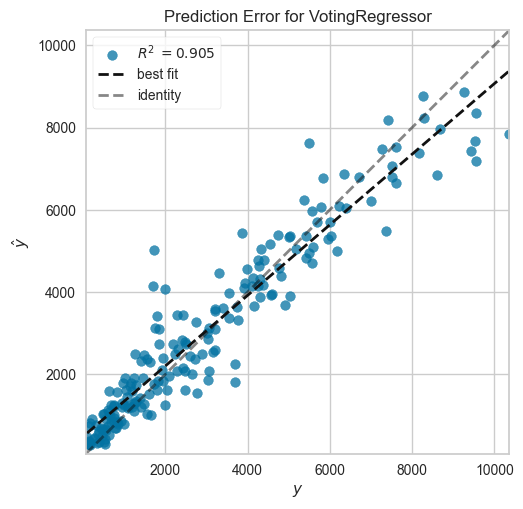

In [240]:
plot_model(final_tuned, plot = 'error')

In [241]:
plot_model(final_tuned, plot = 'residuals_interactive')

    'data': [{'hovertemplate': 'Split=train<br>Predictions…

### Finalized Model

In [242]:
finalized_model_user = finalize_model(final_tuned)

In [243]:
predictions = predict_model(finalized_model_user, data=data_unseen)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,593.5245,881178.5848,938.7111,0.8660,0.4722,0.3063


In [244]:
data_adj = data
data_adj_unseen = data_unseen

### Summary of Model Progress

In [251]:
new_data = {
    'Model': 'Cat+XG (2nd Pass Outlier Removal)',
    'Version': 'M_D1',
    'Dataset': 'df_user',
    'MAE': 521.4628,
    'MSE': 534246.5738,
    'RMSE': 730.9217,
    'R2': 0.9128,
    'RMSLE': 0.3436,
    'MAPE': 0.2812
}

combined_metrics.loc[len(combined_metrics)] = new_data

In [252]:
combined_metrics

,Model,Version,Dataset,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Model First Pass,M_A1,Base df,2036.8804,3.278083e+07,5725.4545,0.3923,0.8174,0.7291
1,CatBoost Base (After 1st Pass Outlier Removal),M_B1,df_adj,644.6227,1.222307e+06,1105.5800,0.8296,0.4249,0.3163
2,CatBoost Tuned,M_B2,df_adj,718.8183,1.421751e+06,1192.3719,0.8018,0.4680,0.4183
3,CatBoost Bagged,M_B3,df_adj,718.8183,1.421751e+06,1192.3719,0.8018,0.4680,0.4183
4,Blended,M_B4,df_adj,666.0686,1.316413e+06,1147.3505,0.8164,0.3772,0.3169
5,Blended & Tuned,M_B5,df_adj,650.6519,1.276483e+06,1129.8153,0.8220,0.3705,0.3065
7,CatBoost Model + Feature Reduction,M_C1,df_adj,744.1359,1.116342e+06,1056.5707,0.8252,0.3749,0.3384
8,CatBoost Model + 2nd Degree Polynomial Features,M_C2,df_adj,903.4904,1.683482e+06,1297.4908,0.7643,0.4298,0.3967
9,Cat+XG (2nd Pass Outlier Removal),M_D1,df_user,521.4628,5.342466e+05,730.9217,0.9128,0.3436,0.2812


In [253]:
with open('pickles/data_adj.pkl', 'wb') as f:
    pickle.dump(data_adj, f)
with open('pickles/data_adj_unseen.pkl', 'wb') as f:
    pickle.dump(data_adj_unseen, f)
with open('pickles/combined_metrics.pkl', 'wb') as f:
    pickle.dump(combined_metrics, f)